# _TACTICAL ASSET ALLOCATION AND MACHINE LEARNING_

**Student ID**: 34421, Pierfrancesco Gigli

In [1]:
## libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import datetime

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif 
from sklearn.feature_selection import f_classif 
from sklearn.feature_selection import chi2
from sklearn.model_selection import TimeSeriesSplit

import urllib

from scipy import stats

from tabulate import tabulate

import warnings
warnings.filterwarnings('ignore')

# I.   Data Curation

In [2]:
BOB=pd.read_excel("1920S2_34421_Pierfrancesco_Gigli_Part 2.xlsx", sheet_name="BOB")
FRED=pd.read_excel("1920S2_34421_Pierfrancesco_Gigli_Part 2.xlsx", sheet_name="FRED")
INDU=pd.read_excel("1920S2_34421_Pierfrancesco_Gigli_Part 2.xlsx", sheet_name="PRICE_INDU")
rf=pd.read_excel("1920S2_34421_Pierfrancesco_Gigli_Part 2.xlsx", sheet_name="rf")
ALLAN=pd.read_excel("1920S2_34421_Pierfrancesco_Gigli_Part 2.xlsx", sheet_name="ALLAN")

Text(0.5, 1.0, 'Dow Jones Industrial Average Index')

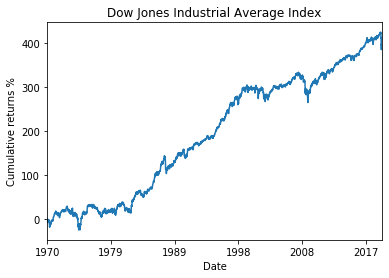

In [3]:
## Data Curation INDU
INDU=pd.DataFrame(INDU.iloc[5:,6:8])
INDU.columns=["Date", "DWJ_price"]
INDU["DWJ_price"]=pd.Series(INDU["DWJ_price"], dtype="float64")
ret_INDU=INDU["DWJ_price"].pct_change().fillna(0)*100
INDU['return']=ret_INDU

## DowJones Price plot
index=INDU["Date"].dt.strftime('%Y')
pd.Series(np.array(INDU['return']), index=index).cumsum().plot()
plt.ylabel("Cumulative returns %")
plt.title("Dow Jones Industrial Average Index")

In [4]:
df1=FRED.iloc[5:,1::3]
df1.columns=['EHGDUSY','EHUPUS','RSTAMOM','USTBTOT','NWORCHNG','AAIIBULL','AAIIBEAR','PCE CMOM','IP CHNG',
              'CHPMINDX','IPMGCHNG', 'FDDSSD','PITLCHNG','NHSLCHNG']
date_df1=FRED.iloc[5:,0::3]

EHGDUSY=pd.DataFrame([df1.EHGDUSY,date_df1.iloc[:,0]], index=['EHGDUSY', 'Date']).T.dropna()
EHGDUSY.index=EHGDUSY['Date']
EHGDUSY=EHGDUSY.resample('M').ffill()
EHUPUS=pd.DataFrame([df1.EHUPUS,date_df1.iloc[:,1]], index=['EHUPUS', 'Date']).T.dropna()
EHUPUS.index=EHUPUS['Date']
EHUPUS=EHUPUS.resample('M').ffill()
RSTAMOM=pd.DataFrame([df1.RSTAMOM,date_df1.iloc[:,2]], index=['RSTAMOM', 'Date']).T.dropna()
RSTAMOM.index=RSTAMOM['Date']

AAIIBULL=pd.DataFrame(df1.iloc[:,5]).dropna()
AAIIBULL['Date']=date_df1.iloc[:,5].dropna()
AAIIBULL.index=AAIIBULL['Date']
AAIIBEAR=pd.DataFrame(df1.iloc[:,6]).dropna()
AAIIBEAR['Date']=date_df1.iloc[:,6].dropna()
AAIIBEAR.index=AAIIBEAR['Date']
AAIIBULL=AAIIBULL.resample('M').ffill()
AAIIBEAR=AAIIBEAR.resample('M').ffill()

USTBTOT=pd.DataFrame([df1['USTBTOT']], index=['USTBTOT']).T.shift(1)
USTBTOT['Date']=date_df1.iloc[:,3]
USTBTOT.index=USTBTOT['Date']
USTBTOT=USTBTOT['USTBTOT'].dropna().reset_index()
USTBTOT['Date']=AAIIBEAR.index[55:]
USTBTOT.index=USTBTOT['Date']

NWORCHNG= pd.DataFrame([df1.NWORCHNG,date_df1.iloc[:,4]], index=['NWORCHNG', 'Date']).T.dropna()
NWORCHNG.index=NWORCHNG['Date']
NWORCHNG=NWORCHNG.resample('M').ffill()


PCE_CMOM=pd.DataFrame([df1['PCE CMOM']], index=['PCE CMOM']).T.shift(1)
PCE_CMOM['Date']=date_df1.iloc[:,7]
PCE_CMOM.index=PCE_CMOM['Date']
IP_CHNG= pd.DataFrame([df1['IP CHNG'],date_df1.iloc[:,8]], index=['IP CHNG', 'Date']).T.dropna()
IP_CHNG.index=IP_CHNG['Date']
CHPMINDX= pd.DataFrame([df1['CHPMINDX'],date_df1.iloc[:,9]], index=['CHPMINDX', 'Date']).T.dropna()
CHPMINDX.index=IP_CHNG['Date']
IPMGCHNG=pd.DataFrame([df1['IPMGCHNG'],date_df1.iloc[:,10]], index=['IPMGCHNG', 'Date']).T.dropna()
IPMGCHNG.index=IPMGCHNG['Date']
FDDSSD=pd.DataFrame([df1['FDDSSD'],date_df1.iloc[:,11]], index=['FDDSSD', 'Date']).T.dropna()
FDDSSD.index=FDDSSD['Date']
PITLCHNG=pd.DataFrame([df1['PITLCHNG'],date_df1.iloc[:,12]], index=['PITLCHNG', 'Date']).T.dropna()
PITLCHNG.index=PITLCHNG['Date']
NHSLCHNG=pd.DataFrame([df1['NHSLCHNG'],date_df1.iloc[:,13]], index=['NHSLCHNG', 'Date']).T.dropna()
NHSLCHNG.index=NHSLCHNG['Date']

## generate final FRED DataSet starting from 1992
fred1= pd.concat([EHGDUSY,EHUPUS],join='outer',axis=1)[['EHGDUSY','EHUPUS']]
fred2= pd.concat([RSTAMOM,fred1],join='outer',axis=1)[['EHGDUSY','EHUPUS','RSTAMOM']]
fred3= pd.concat([fred2,USTBTOT],join='outer',axis=1)[['EHGDUSY','EHUPUS','RSTAMOM','USTBTOT']]
fred4= pd.concat([fred3,NWORCHNG],join='outer',axis=1)[['EHGDUSY','EHUPUS','RSTAMOM','USTBTOT','NWORCHNG']]
fred5= pd.concat([fred4,PCE_CMOM],join='outer',axis=1)[['EHGDUSY','EHUPUS','RSTAMOM','USTBTOT','NWORCHNG','PCE CMOM']]
fred6= pd.concat([fred5,IP_CHNG],join='outer',axis=1)[['EHGDUSY','EHUPUS','RSTAMOM','USTBTOT','NWORCHNG','PCE CMOM','IP CHNG']]
fred7= pd.concat([fred6,IPMGCHNG],join='outer',axis=1)[['EHGDUSY','EHUPUS','RSTAMOM','USTBTOT','NWORCHNG','PCE CMOM',
                                                                 'IP CHNG','IPMGCHNG']]
fred8= pd.concat([fred7,FDDSSD],join='outer',axis=1)[['EHGDUSY','EHUPUS','RSTAMOM','USTBTOT','NWORCHNG','PCE CMOM',
                                                                 'IP CHNG','IPMGCHNG','FDDSSD']]
fred9= pd.concat([fred8,PITLCHNG],join='outer',axis=1)[['EHGDUSY','EHUPUS','RSTAMOM','USTBTOT','NWORCHNG','PCE CMOM',
                                                                 'IP CHNG','IPMGCHNG','FDDSSD','PITLCHNG']]

fred10= pd.concat([fred9,NHSLCHNG],join='outer',axis=1)[['EHGDUSY','EHUPUS','RSTAMOM','USTBTOT','NWORCHNG','PCE CMOM',
                                                         'IP CHNG','IPMGCHNG','FDDSSD','PITLCHNG','NHSLCHNG']]
fred11= pd.concat([fred10,CHPMINDX],join='outer',axis=1)[['EHGDUSY','EHUPUS','RSTAMOM','USTBTOT','NWORCHNG','PCE CMOM',
                                                         'IP CHNG','IPMGCHNG','FDDSSD','PITLCHNG','NHSLCHNG','CHPMINDX']]
INDU_monthly=INDU[["Date","DWJ_price"]]
INDU_monthly.index=INDU["Date"]
INDU_monthly=pd.DataFrame(INDU_monthly[["DWJ_price"]].resample('M').ffill())
fred_nolag= pd.concat([fred11,INDU_monthly],join='outer',axis=1)[['EHGDUSY','EHUPUS','RSTAMOM','USTBTOT','NWORCHNG','PCE CMOM',
                                                                'IP CHNG','IPMGCHNG','FDDSSD','PITLCHNG',
                                                                  'NHSLCHNG','CHPMINDX', 'DWJ_price']]
FRED=pd.DataFrame(fred_nolag.shift(1), index=fred_nolag.index)
FRED=FRED.fillna(method='ffill')
FRED.dropna(inplace=True)

In [5]:
## the AAII survay should not be in the FRED data but in the ALLAN, since it is a sentiment

In [6]:
## Data Curation ALLAN
df2=ALLAN.iloc[5:,1::3]
df2.columns=['INJCJC','NFP TCH','MWINCHNG','NAPMNMI','NAPMPMI','CL1','GOLD',
             'VIX','LEI CHNG', 'USGG10YR']
date_df2=ALLAN.iloc[5:,0::3]

## create individual DataSets for each variable
INJCJC=pd.DataFrame([df2.INJCJC,date_df2.iloc[:,0]], index=['INJCJC', 'Date']).T
INJCJC.index=INJCJC['Date']
INJCJC=INJCJC.resample('M').ffill()
NFP_TCH=pd.DataFrame([df2['NFP TCH']], index=['NFP TCH']).T.shift(1)
NFP_TCH['Date']=date_df2.iloc[:,1]
NFP_TCH.dropna()
NFP_TCH.index=NFP_TCH['Date']
MWINCHNG=pd.DataFrame([df2['MWINCHNG'],date_df2.iloc[:,2]], index=['MWINCHNG', 'Date']).T.dropna()
MWINCHNG.index=MWINCHNG['Date']
NAPMNMI=pd.DataFrame([df2['NAPMNMI'],date_df2.iloc[:,3]], index=['NAPMNMI', 'Date']).T.dropna()
NAPMNMI.index=NAPMNMI['Date']
NAPMPMI=pd.DataFrame([df2['NAPMPMI'],date_df2.iloc[:,4]], index=['NAPMPMI', 'Date']).T.dropna()
NAPMPMI.index=NAPMPMI['Date']
CL1=pd.DataFrame([df2['CL1'],date_df2.iloc[:,5]], index=['CL1', 'Date']).T
CL1.index=CL1['Date']
CL1=CL1.dropna().resample('M').ffill()
GOLD=pd.DataFrame([df2['GOLD'],date_df2.iloc[:,6]], index=['GOLD', 'Date']).T
GOLD.index=GOLD['Date']
GOLD=GOLD.dropna().resample('M').ffill()
VIX=pd.DataFrame([df2['VIX'],date_df2.iloc[:,7]], index=['VIX', 'Date']).T
VIX.index=VIX['Date']
VIX=VIX.dropna().resample('M').ffill()
LEI_CHNG=pd.DataFrame([df2['LEI CHNG'],date_df2.iloc[:,8]], index=['LEI CHNG', 'Date']).T.dropna()
LEI_CHNG.index=LEI_CHNG['Date']
USGG10YR=pd.DataFrame([df2['USGG10YR'],date_df2.iloc[:,9]], index=['USGG10YR', 'Date']).T.dropna()
USGG10YR.index=USGG10YR['Date']
USGG10YR=USGG10YR.dropna().resample('M').ffill()

## generate final ALLAN DataSet starting from 1997
allan1= pd.concat([NAPMNMI,NAPMPMI],join='outer',axis=1)[['NAPMNMI','NAPMPMI']]
allan2= pd.concat([allan1,MWINCHNG],join='outer',axis=1)[['NAPMNMI','NAPMPMI','MWINCHNG']]
allan3= pd.concat([allan2,NFP_TCH.dropna()],join='outer',axis=1)[['NAPMNMI','NAPMPMI','MWINCHNG','NFP TCH']]
allan4= pd.concat([allan3,INJCJC],join='outer',axis=1 )[['NAPMNMI','NAPMPMI','MWINCHNG','NFP TCH','INJCJC']]
allan5= pd.concat([allan4,CL1],join='outer',axis=1 )[['NAPMNMI','NAPMPMI','MWINCHNG','NFP TCH','INJCJC','CL1']]
allan6= pd.concat([allan5,VIX],join='outer',axis=1 )[['NAPMNMI','NAPMPMI','MWINCHNG','NFP TCH','INJCJC','CL1','VIX']]
allan7= pd.concat([allan6,GOLD],join='outer',axis=1 )[['NAPMNMI','NAPMPMI','MWINCHNG','NFP TCH',
                                                                'INJCJC','CL1','VIX','GOLD']]
allan8= pd.concat([allan7,LEI_CHNG],join='outer',axis=1)[['NAPMNMI','NAPMPMI','MWINCHNG','NFP TCH',
                                                                'INJCJC','CL1','VIX','GOLD','LEI CHNG']]
allan9= pd.concat([allan8,USGG10YR],join='outer',axis=1 )[['NAPMNMI','NAPMPMI','MWINCHNG','NFP TCH',
                                                                'INJCJC','CL1','VIX','GOLD','LEI CHNG','USGG10YR']]

allan10= pd.concat([allan9,AAIIBULL],join='outer',axis=1)[['NAPMNMI','NAPMPMI','MWINCHNG','NFP TCH',
                                                                'INJCJC','CL1','VIX','GOLD','LEI CHNG','USGG10YR',
                                                                 'AAIIBULL']]

allan_nolag= pd.concat([allan10,AAIIBEAR],join='outer',axis=1)[['NAPMNMI','NAPMPMI','MWINCHNG','NFP TCH',
                                                                'INJCJC','CL1','VIX','GOLD','LEI CHNG','USGG10YR',
                                                                      'AAIIBULL','AAIIBEAR']]
allan_nolag= allan_nolag.fillna(method='ffill').dropna()
ALLAN=pd.DataFrame(allan_nolag[['NAPMNMI','NAPMPMI','MWINCHNG','NFP TCH',
                                                                'LEI CHNG', 'AAIIBULL','AAIIBEAR']].shift(1), index=allan_nolag.index).astype('float64').dropna()

In [7]:
ALLAN= pd.concat([ALLAN,INJCJC],join='outer',axis=1 )[['NAPMNMI','NAPMPMI','MWINCHNG','NFP TCH',
                                                                'LEI CHNG', 'AAIIBULL','AAIIBEAR','INJCJC']]
ALLAN= pd.concat([ALLAN,CL1],join='outer',axis=1 )[['NAPMNMI','NAPMPMI','MWINCHNG','NFP TCH',
                                                                'LEI CHNG', 'AAIIBULL','AAIIBEAR','INJCJC','CL1']]
ALLAN= pd.concat([ALLAN,VIX],join='outer',axis=1 )[['NAPMNMI','NAPMPMI','MWINCHNG','NFP TCH',
                                                                'LEI CHNG', 'AAIIBULL','AAIIBEAR','INJCJC','CL1','VIX']]
ALLAN= pd.concat([ALLAN,GOLD],join='outer',axis=1 )[['NAPMNMI','NAPMPMI','MWINCHNG','NFP TCH',
                                                                'LEI CHNG', 'AAIIBULL','AAIIBEAR','INJCJC','CL1','VIX','GOLD']]
ALLAN= pd.concat([ALLAN,USGG10YR],join='outer',axis=1 )[['NAPMNMI','NAPMPMI','MWINCHNG','NFP TCH',
                                                                'LEI CHNG', 'AAIIBULL','AAIIBEAR',
                                                        'INJCJC','CL1','VIX','GOLD','USGG10YR']]

In [8]:
ALLAN["CL1"]=ALLAN.CL1.pct_change()*100
ALLAN["VIX"]=ALLAN.VIX.pct_change()*100
ALLAN["GOLD"]=ALLAN.GOLD.pct_change()*100
ALLAN["INJCJC"]=ALLAN.INJCJC.pct_change()*100
ALLAN["USGG10YR"]=ALLAN.USGG10YR.pct_change()*100
ALLAN.dropna(inplace=True)

In [9]:
## Data Curation BOB 
BOB.columns=["Date", "DVD_yield", "P/E"]
BOB=BOB[5:]
BOB["Earning_yield"]=pd.Series(1/BOB["P/E"], dtype="float64")
BOB["P/DVD"]=pd.Series(1/BOB["DVD_yield"], dtype="float64")

Text(0.5, 1.0, "Generic 1st 'TY' Future")

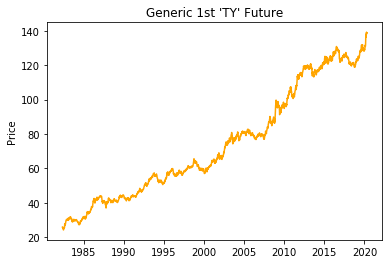

In [10]:
## Data Curation rf
rf=rf.iloc[5:,0:2]
rf.columns=["Date", "TY1_Futures"]
rf["TY1_Futures"]=pd.Series(rf["TY1_Futures"],dtype="float64")

## 10 Years US Treasury price
plt.plot(rf['Date'],rf['TY1_Futures'],color="orange")
plt.ylabel("Price")
plt.title("Generic 1st 'TY' Future")

In [11]:
rf['return'] = rf["TY1_Futures"].pct_change().fillna(0)*100


Text(0.5, 1.0, 'US Government 10 Year Treasury')

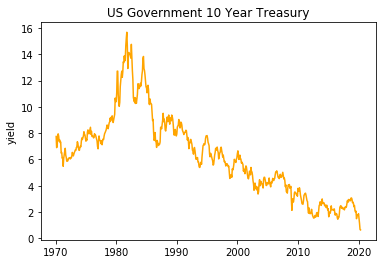

In [12]:
## 10 Years US Treasury yield

plt.plot(USGG10YR.index,USGG10YR['USGG10YR'],color="orange")
plt.ylabel("yield")
plt.title("US Government 10 Year Treasury")

Text(0, 0.5, 'Returns')

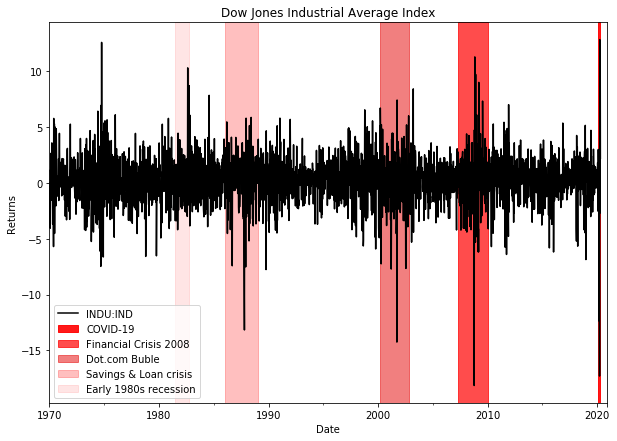

In [13]:
## Crisis Map
fig, axes = plt.subplots(1,1, figsize=(10,7), sharex=True)
index= pd.to_datetime(INDU["Date"].dt.strftime('%Y-%m-%d'))
pd.Series(np.array(INDU['return']), index=index).plot(color="black",alpha=1, label="INDU:IND")
plt.title("Dow Jones Industrial Average Index")

axes.axvspan("2020-02","2020-04", color='red', alpha=0.9, label="COVID-19")
axes.axvspan("2007-04-06","2009-12-31", color='red', alpha=0.7, label="Financial Crisis 2008")
axes.axvspan("2000-03-10","2002-10-25", color=sns.xkcd_rgb['red'], alpha=0.5, label="Dot.com Buble")
axes.axvspan("1986","1989", color='red', alpha=0.25, label="Savings & Loan crisis")
axes.axvspan("1981-07","1982-10", color='red', alpha=0.1, label="Early 1980s recession")

plt.xlim([datetime.date(1970, 1, 1),datetime.date(2020, 11, 30)])

plt.legend(loc="best")
plt.ylabel("Returns")

In [14]:
## Data Frame between BOB and Index return
df=pd.merge(BOB, INDU)
df.index=df["Date"]
rf.index=rf["Date"]
df=df.merge(rf,left_index=True,right_index=True)
df=df[["Earning_yield","DWJ_price","P/DVD", "TY1_Futures"]]


# II.  Results and Findings

## BOB Model

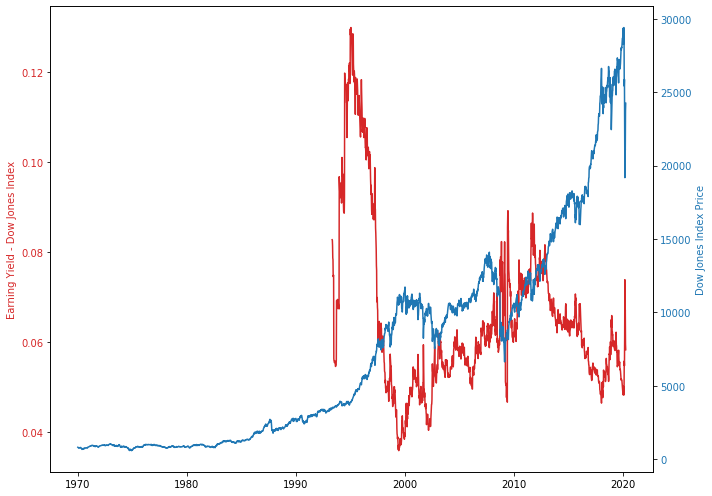

In [15]:
## Earning Yield plot vs INDU Index
fig, ax1 = plt.subplots(figsize=(10,7))

color = 'tab:red'
ax1.set_ylabel('Earning Yield - Dow Jones Index', color=color)
ax1.plot(BOB["Date"],BOB['Earning_yield'] , color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Dow Jones Index Price', color=color)
ax2.plot(BOB["Date"], INDU["DWJ_price"], color=color)
ax2.tick_params(axis='y', labelcolor=color)


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

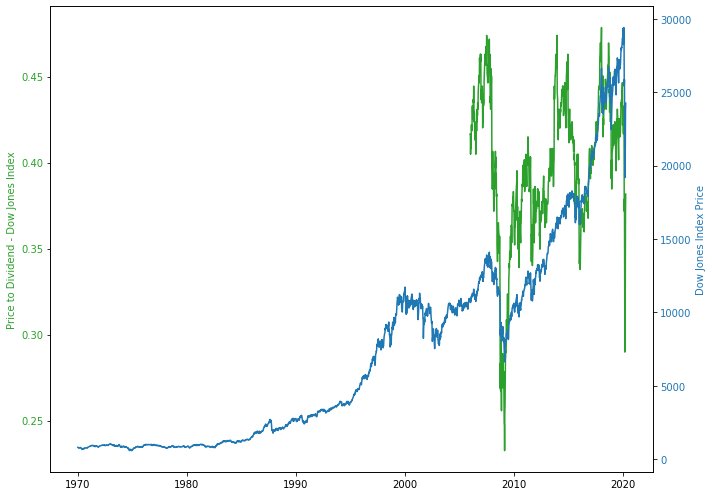

In [16]:
## Price to DVD ratio vs INDU index
fig, ax1 = plt.subplots(figsize=(10,7))

color = 'tab:green'
ax1.set_ylabel('Price to Dividend - Dow Jones Index', color=color)
ax1.plot(BOB["Date"],BOB['P/DVD'] , color=color, label="P/D")
ax1.tick_params(axis='y', labelcolor=color)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Dow Jones Index Price', color=color)
ax2.plot(BOB["Date"], INDU["DWJ_price"], color=color)
ax2.tick_params(axis='y', labelcolor=color)


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [17]:
df_BOB=df.resample('M').ffill()

df_BOB["P/DVD_Blag3M"]=df_BOB["P/DVD"].shift(3)
df_BOB["P/DVD_Blag6M"]=df_BOB["P/DVD"].shift(6)

df_BOB["Earning_yield_Blag3M"]=df_BOB["Earning_yield"].shift(3).astype("float64")
df_BOB["Earning_yield_Blag6M"]=df_BOB["Earning_yield"].shift(6).astype("float64")

df_BOB.columns=['Earning_yield', 'DWJ_price', 'P/DVD', 'TY1_Futures', 'P/DVD3M',
       'P/DVD6M', 'Earning_yield3M', 'Earning_yield6M']

                 DWJ_price   P/DVD3M   P/DVD6M  Earning_yield3M  \
DWJ_price         1.000000  0.498343  0.462972        -0.417893   
P/DVD3M           0.498343  1.000000  0.803852        -0.523825   
P/DVD6M           0.462972  0.803852  1.000000        -0.376617   
Earning_yield3M  -0.417893 -0.523825 -0.376617         1.000000   
Earning_yield6M  -0.396091 -0.441502 -0.516851         0.921386   

                 Earning_yield6M  
DWJ_price              -0.396091  
P/DVD3M                -0.441502  
P/DVD6M                -0.516851  
Earning_yield3M         0.921386  
Earning_yield6M         1.000000  


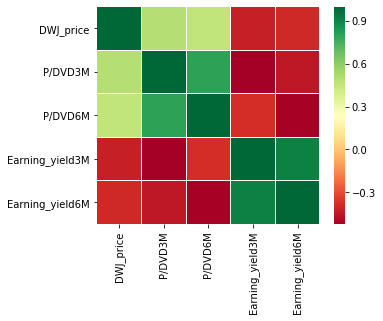

In [18]:
## Correlation Matrix

corrmat = df_BOB.drop(["Earning_yield","P/DVD","TY1_Futures"],axis=1).corr() 
print(corrmat)
## plot the correlation matrix
f, ax = plt.subplots(figsize =(5, 4)) 
sns.heatmap(corrmat, ax = ax, cmap ="RdYlGn", linewidths = 0.1) 

In [19]:
df_BOB_TY1=df_BOB["TY1_Futures"]
df_BOB.drop(["Earning_yield","P/DVD","TY1_Futures"],axis=1, inplace=True)

df_BOB=df_BOB.dropna()

In [20]:
min_max_scaler = preprocessing.MinMaxScaler()
df_BOB_transf= pd.DataFrame(min_max_scaler.fit_transform(df_BOB.drop(['DWJ_price'],axis=1)), columns=df_BOB.drop(['DWJ_price'],axis=1).columns,
                       index=df_BOB.index)
df_BOB_transf['DWJ_price']=df_BOB.DWJ_price
df_BOB=df_BOB_transf

In [21]:
## Split between TRAIN & TEST Set BOB data set
X_full, y_full = np.array(df_BOB.drop(["DWJ_price"],axis=1)), np.log(np.array(df_BOB["DWJ_price"]))
X=pd.DataFrame(X_full,index=df_BOB.index, columns=df_BOB.drop(["DWJ_price"],axis=1).columns)

X_train=np.array(X[:"2016-01-01"])
X_test=np.array(X["2016-01-01":])


y=pd.DataFrame(y_full,index=df_BOB.index, columns=['DWJ_price'])
y_train=list(itertools.chain.from_iterable(y[:"2016-01-01"].values))
y_test=list(itertools.chain.from_iterable(y["2016-01-01":].values))


In [22]:
# Use grid search to tune the parameters:

parametersGrid = {"max_iter": [1000],
                      "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                      "l1_ratio": np.arange(0.0, 1.1, 0.1)}
## elastic net regularization
eNet = ElasticNet()
## (cross validation 5, means about 2y in each folds)
elnet_reg_best = GridSearchCV(eNet, parametersGrid, scoring='neg_mean_squared_error', cv=5)
elnet_reg_best.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'max_iter': [1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [23]:
elnet_reg_best.best_estimator_, elnet_reg_best.best_params_, elnet_reg_best.best_score_

(ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True, l1_ratio=1.0,
            max_iter=1000, normalize=False, positive=False, precompute=False,
            random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
 {'alpha': 0.001, 'l1_ratio': 1.0, 'max_iter': 1000},
 -0.045394773831084555)

In [24]:
elnet_reg_best.best_estimator_.coef_  , elnet_reg_best.best_estimator_.intercept_

(array([0.61647047, 0.29969108, 0.12447797, 0.29878259]), 8.66902212149647)

4 features, reduction of 0.00%


Text(0.5, 1.0, "Features' importance - BOB Dataset")

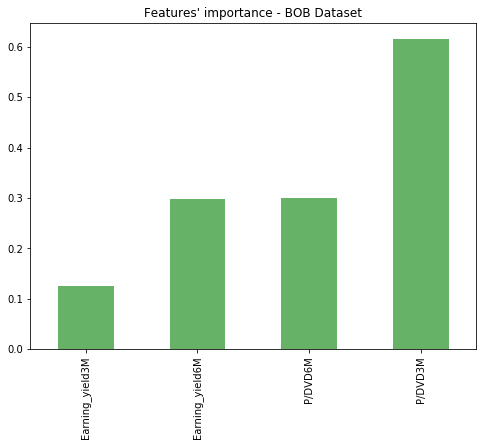

In [25]:
## features importance plot
feature_importance = pd.Series(index = X.columns, data = np.abs(elnet_reg_best.best_estimator_.coef_))

n_selected_features = (feature_importance>0).sum()
print('{0:d} features, reduction of {1:2.2f}%'.format(
    n_selected_features,(1-n_selected_features/len(feature_importance))*100))

feature_importance.sort_values().tail(30).plot(kind = 'bar', figsize = (8,6), alpha=0.6, color="green")
plt.title("Features' importance - BOB Dataset")

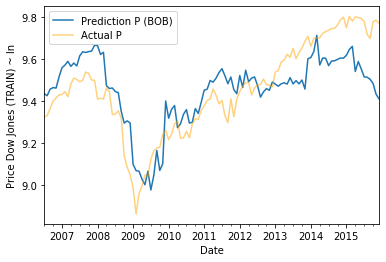

In [26]:
## TRAINING SET Predictions
y_pred_train=elnet_reg_best.predict(X_train)

## plot
pd.Series(y_pred_train, index=y[:"2016-01-01"].index).plot(label="Prediction P (BOB)")
pd.Series(y_train, index=y[:"2016-01-01"].index).plot(color="orange",alpha=0.5, label="Actual P")
plt.ylabel("Price Dow Jones (TRAIN) ~ ln")
plt.legend(loc="best")

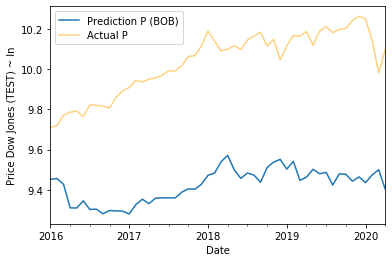

In [27]:
## TEST SET Predictions
y_pred_test=elnet_reg_best.predict(X_test)

## plot 
pd.Series(y_pred_test, index=y["2016-01-01":].index).plot(label="Prediction P (BOB)")
pd.Series(y_test, index=y["2016-01-01":].index).plot(color="orange",alpha=0.5, label="Actual P")
plt.ylabel("Price Dow Jones (TEST) ~ ln")
plt.legend(loc="best")

In [28]:
## Mean Square Error on the Train and Test Set vs predictions                       
mse_train_train = mean_squared_error(y_train, y_pred_train)
mse_test_test = mean_squared_error(y_test, y_pred_test)
print("MSE (train)\n", mse_train_train)
print("MSE (test)\n", mse_test_test)

MSE (train)
 0.01869256335138467
MSE (test)
 0.38686403686101545


In [29]:
## Maybe an accuracy matrix?? 
return_test=pd.Series(y_test, index=y["2016-01-01":].index).pct_change()
return_pred=pd.Series(y_pred_test, index=y["2016-01-01":].index).pct_change()
true_positive=0
true_negative=0
false_positive=0
false_negative=0
for i in range(1,len(return_pred)):
    
    if (return_test[i]>0) & (return_pred[i]>0):
        true_positive+=1
    elif (return_test[i]<0) & (return_pred[i]<0):
        true_negative+=1
    elif (return_test[i]>0) & (return_pred[i]<0):
        false_negative +=1
    elif (return_test[i]<0) & (return_pred[i]>0):
        false_positive +=1
        
print("Pseudo Accuracy Matrix: ")
print(true_positive,false_negative)
print(false_positive,true_negative)

Pseudo Accuracy Matrix: 
16 18
11 6


In [30]:
print("Precision Rate : {:0.2f}%".format((true_positive/(true_positive+false_positive))*100))
print("Recall Rate : {:0.2f}%".format((true_positive/(true_positive+false_negative))*100))
print("Accuracy Rate : {:0.2f}%".format(((true_positive+true_negative)/(true_positive+false_negative+true_negative+false_positive))*100))

Precision Rate : 59.26%
Recall Rate : 47.06%
Accuracy Rate : 43.14%


In [31]:
## Prediction Dow Jones Industrial Average (Test)
df_test_forecast=pd.DataFrame(y_pred_test, columns=["Dow Jones Index"], index=y["2016-01-01":].index)

## risk free return 
df_BOB['TY1_Futures']=df_BOB_TY1
risk_free=pd.Series(df_BOB["2016-01-01":]['TY1_Futures']).pct_change().fillna(0)*100

## Return of Dow Jones Industrial Average (Test)
monthly_price=pd.Series(df_BOB["2016-01-01":]['DWJ_price'])
m_ret=monthly_price.pct_change().fillna(0)*100

## Return of Predicted Dow Jones Industrial Average (Test)
monthly_forecast_BOB=df_test_forecast["Dow Jones Index"]
m_ret_forward_BOB=monthly_forecast_BOB.pct_change().fillna(0)*100

prct_25=m_ret_forward_BOB.describe()["25%"] ## 25th percentile 
prct_75=m_ret_forward_BOB.describe()["75%"] ## 75th percentile

Text(0.5, 1.0, 'BOX-plot Forecasts BOB')

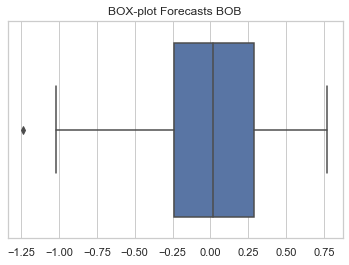

In [32]:
sns.set(style="whitegrid")

ax = sns.boxplot(x=m_ret_forward_BOB)
plt.xlabel("")
plt.title("BOX-plot Forecasts BOB")

Text(0.5, 0, '')

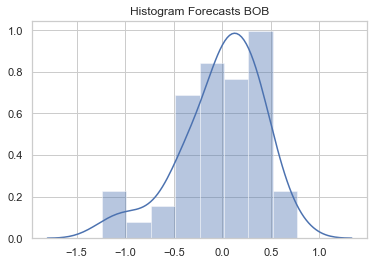

In [33]:
sns.distplot(m_ret_forward_BOB)
plt.title("Histogram Forecasts BOB")
plt.xlabel("")
plt.xlabel("")

In [34]:
## Portfolio Returns
def Portfolio_Return_BOB():
    #global Portfolio_ret_BOB
    w_equity=float(input("Enter weight on Equity: "))
    w_bond=float(input("Enter weight on Bond: "))
    
    if (w_equity+w_bond)==1:

        global Portfolio_ret_BOB
        Portfolio_ret_BOB=[]

        for j in range(0, len(m_ret_forward_BOB)):   

            if (m_ret_forward_BOB[j]>=0) & (m_ret_forward_BOB[j]<prct_75):
                p_ret=((w_equity+0.1)*m_ret[j]+(w_bond-0.1)*risk_free[j])
                message="Overweight Dow Jones ({0:2.2f}%) + Underweight US 10Y Treasury ({1:2.2f}%)".format((w_equity+0.1)*100,(w_bond-0.1)*100)

            elif m_ret_forward_BOB[j]>=prct_75:
                p_ret=((w_equity+0.2)*m_ret[j]+(w_bond-0.2)*risk_free[j])
                message="Overweight Dow Jones ({0:2.2f}%) + Underweight US 10Y Treasury ({1:2.2f}%)".format((w_equity+0.2)*100,(w_bond-0.2)*100)

            elif (m_ret_forward_BOB[j]<0) &(m_ret_forward_BOB[j]>prct_25):
                p_ret=((w_equity-0.1)*m_ret[j]+(0.1+w_bond)*risk_free[j])
                message="Underweight Dow Jones ({0:2.2f}%) + Overweight US 10Y Treasury ({1:2.2f}%)".format((w_equity-0.1)*100,(0.1+w_bond)*100)

            elif (m_ret_forward_BOB[j]<=prct_25):
                p_ret=((w_equity-0.2)*m_ret[j]+(0.2+w_bond)*risk_free[j])
                message="Underweight Dow Jones ({0:2.2f}%) + Overweight US 10Y Treasury ({1:2.2f}%)".format((w_equity-0.2)*100,(0.2+w_bond)*100)

            Portfolio_ret_BOB.append([p_ret,message])
    else:
        return print("Error: The sum of the weight must be 1")



In [35]:
Portfolio_Return_BOB()

Enter weight on Equity: 0.4
Enter weight on Bond: 0.6


In [36]:
y_pred_train_BOB=y_pred_train
BOB_Portfolio= pd.DataFrame([item[0] for item in Portfolio_ret_BOB], columns=["p_BOB_ret"], 
                              index=monthly_forecast_BOB.index)
BOB_Portfolio["message"]=pd.Series([item[1] for item in Portfolio_ret_BOB], 
                                     index=monthly_forecast_BOB.index).shift(-1).fillna("END")

In [37]:
## Benchmark 40 Equity + 60 US 10Y Treasury Bill
benchmark=[]
for j in range(0, len(m_ret_forward_BOB)-1):
    res=(0.4*m_ret[j]+0.6*risk_free[j])
    benchmark.append(res)

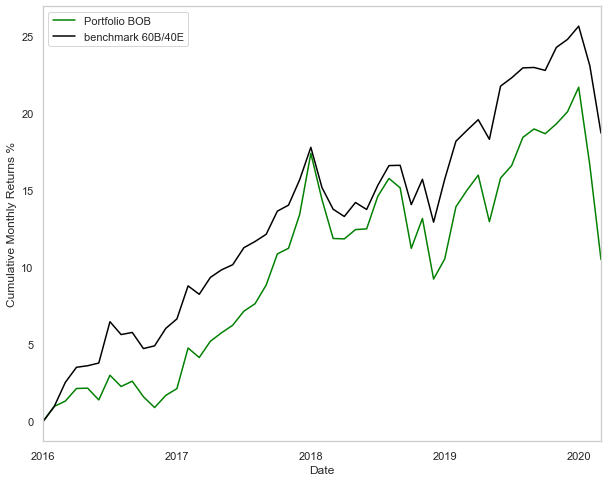

In [38]:
BOB_Portfolio.p_BOB_ret[:-1].cumsum().plot(label="Portfolio BOB", figsize=(10,8), c='green')

pd.Series(benchmark, index= monthly_forecast_BOB.index[:-1]).cumsum().plot(label="benchmark 60B/40E", c='black')

plt.ylabel("Cumulative Monthly Returns %")
plt.legend(loc="best")
plt.grid()

## FRED model

In [39]:
INDU.index=INDU["Date"]
INDU_monthly=pd.DataFrame(INDU[["Date","DWJ_price"]].resample('M').ffill())

            EHGDUSY1Y  EHUPUS1Q  RSTAMOM1M  USTBTOT2M  NWORCHNG1Q  PCE CMOM1M  \
EHGDUSY1Y    1.000000 -0.654085   0.043754   0.168032    0.095992    0.082161   
EHUPUS1Q    -0.654085  1.000000   0.060985   0.124079   -0.099977   -0.010954   
RSTAMOM1M    0.043754  0.060985   1.000000   0.109479    0.099818   -0.159277   
USTBTOT2M    0.168032  0.124079   0.109479   1.000000   -0.124274    0.045050   
NWORCHNG1Q   0.095992 -0.099977   0.099818  -0.124274    1.000000    0.063131   
PCE CMOM1M   0.082161 -0.010954  -0.159277   0.045050    0.063131    1.000000   
IP CHNG1M    0.030031  0.091223   0.346231   0.210276    0.214943    0.112672   
IPMGCHNG1M   0.051867  0.085821   0.407976   0.239166    0.192938    0.120744   
FDDSSD1M     0.307704 -0.263046   0.039391   0.197582   -0.011585   -0.113623   
PITLCHNG1M   0.084507 -0.053067   0.137542   0.037997    0.136637    0.104943   
NHSLCHNG1M   0.043344  0.020042   0.247049   0.062298    0.014794   -0.001149   
CHPMINDX1M   0.013069  0.136

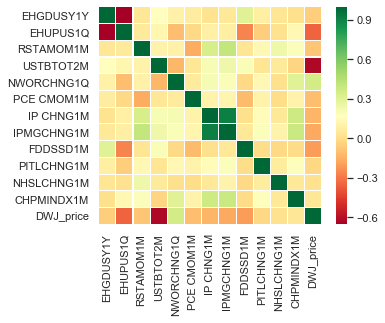

In [40]:
df_FRED=FRED.astype('float64')
df_FRED["DWJ_price"]=INDU_monthly["DWJ_price"]
df_FRED.columns=['EHGDUSY1Y', 'EHUPUS1Q', 'RSTAMOM1M', 'USTBTOT2M', 'NWORCHNG1Q', 'PCE CMOM1M',
       'IP CHNG1M', 'IPMGCHNG1M', 'FDDSSD1M', 'PITLCHNG1M', 'NHSLCHNG1M', 'CHPMINDX1M',
       'DWJ_price']
corrmat = df_FRED.corr() 
print(corrmat)
f, ax = plt.subplots(figsize =(5, 4)) 
sns.heatmap(corrmat, ax = ax, cmap ="RdYlGn", linewidths = 0.1) 

In [41]:
min_max_scaler = preprocessing.MinMaxScaler()
df_FRED_transf= pd.DataFrame(min_max_scaler.fit_transform(df_FRED.drop(['DWJ_price'],axis=1)), columns=df_FRED.columns[:-1],
                       index=df_FRED.index)
df_FRED_transf['DWJ_price']=df_FRED.DWJ_price
df_FRED=df_FRED_transf


In [42]:
## Split between TRAIN & TEST Set BOB data set
X_full, y_full = np.array(df_FRED.drop(['DWJ_price'],axis=1)), np.array(np.log(df_FRED["DWJ_price"]))

X=pd.DataFrame(X_full,index=df_FRED.index, columns=df_FRED.columns[:-1])

X_train=np.array(X[:"2016-01-01"])
X_test=np.array(X["2016-01-01":])


y=pd.DataFrame(y_full,index=df_FRED.index, columns=['DWJ_price'])
y_train=list(itertools.chain.from_iterable(y[:"2016-01-01"].values))
y_test=list(itertools.chain.from_iterable(y["2016-01-01":].values))


In [43]:
 #Use grid search to tune the parameters:

parametersGrid = {"max_iter": [1000],
                      "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                      "l1_ratio": np.arange(0.0, 1.1, 0.1)}

eNet = ElasticNet()
## (cross validation 10, means about 2y in each folds)
elnet_reg_best = GridSearchCV(eNet, parametersGrid, scoring='neg_mean_squared_error', cv=11)
elnet_reg_best.fit(X_train, y_train)

GridSearchCV(cv=11, error_score='raise-deprecating',
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'max_iter': [1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [44]:
elnet_reg_best.best_estimator_, elnet_reg_best.best_params_, elnet_reg_best.best_score_

(ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True, l1_ratio=1.0,
            max_iter=1000, normalize=False, positive=False, precompute=False,
            random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
 {'alpha': 0.001, 'l1_ratio': 1.0, 'max_iter': 1000},
 -0.1384077246821397)

In [45]:
elnet_reg_best.best_estimator_.coef_

array([ 0.11151219, -0.        , -0.        , -1.16915687,  0.87735814,
       -0.83839335,  0.        ,  0.        , -0.05664606, -0.        ,
        0.09774389, -0.29894536])

7 features, reduction of 41.67%


Text(0.5, 1.0, "Features' importance - FRED Dataset")

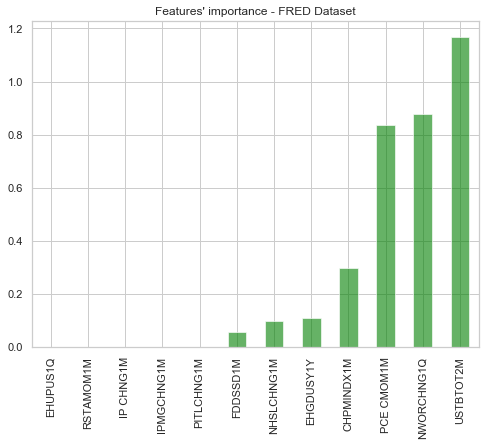

In [46]:
## feature importance
feature_importance = pd.Series(index = X.columns, data = np.abs(elnet_reg_best.best_estimator_.coef_))

n_selected_features = (feature_importance>0).sum()
print('{0:d} features, reduction of {1:2.2f}%'.format(
    n_selected_features,(1-n_selected_features/len(feature_importance))*100))

feature_importance.sort_values().tail(30).plot(kind = 'bar', figsize = (8,6), alpha=0.6, color="green")
plt.title("Features' importance - FRED Dataset")

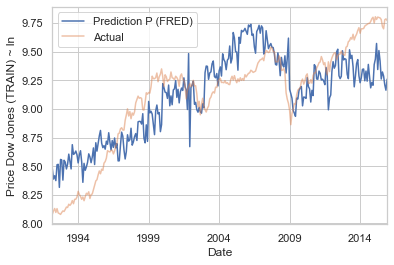

In [47]:
## TRAINING SET Predictions

y_pred_train=elnet_reg_best.predict(X_train)

## plot
pd.Series(y_pred_train, index=y['1992-03-31':"2016-01-01"].index).plot(label="Prediction P (FRED)")
pd.Series(y_train, index=y['1992-03-31':"2016-01-01"].index).plot(alpha=0.5, label="Actual")
plt.ylabel("Price Dow Jones (TRAIN) ~ ln")
plt.legend(loc="best")


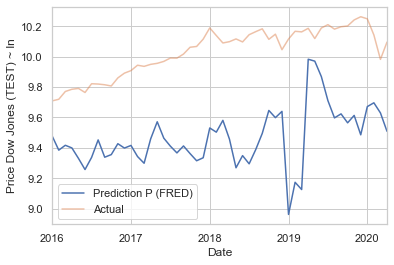

In [48]:
## TEST SET Predictions
y_pred_test=elnet_reg_best.predict(X_test)

## plot 
pd.Series(y_pred_test, index=y["2016-01-01":].index).plot(label="Prediction P (FRED)")
pd.Series(y_test, index=y["2016-01-01":].index).plot(alpha=0.5, label="Actual")
plt.ylabel("Price Dow Jones (TEST) ~ ln")
plt.legend(loc="best")

In [49]:
mse_test_train = mean_squared_error(y_train, y_pred_train)
mse_test_test = mean_squared_error(y_test, y_pred_test)
print("MSE (train)\n", mse_test_train)
print("MSE (test)\n", mse_test_test)

MSE (train)
 0.07212975813725885
MSE (test)
 0.3598487623649926


In [50]:

return_test=pd.Series(y_test, index=y["2016-01-01":].index).pct_change()
return_pred=pd.Series(y_pred_test, index=y["2016-01-01":].index).pct_change()
true_positive=0
true_negative=0
false_positive=0
false_negative=0
for i in range(1,len(return_pred)):
    
    if (return_test[i]>0) & (return_pred[i]>0):
        true_positive+=1
    elif (return_test[i]<0) & (return_pred[i]<0):
        true_negative+=1
    elif (return_test[i]>0) & (return_pred[i]<0):
        false_negative+=1
    elif (return_test[i]<0) & (return_pred[i]>0):
        false_positive+=1
        
print("Pseudo Accuracy Matrix: ")
print(true_positive, false_negative )
print(false_positive,true_negative)

Pseudo Accuracy Matrix: 
15 19
8 9


In [51]:
print("Precision Rate : {:0.2f}%".format((true_positive/(true_positive+false_positive))*100))
print("Recall Rate : {:0.2f}%".format((true_positive/(true_positive+false_negative))*100))
print("Accuracy Rate : {:0.2f}%".format(((true_positive+true_negative)/(true_positive+false_negative+true_negative+false_positive))*100))

Precision Rate : 65.22%
Recall Rate : 44.12%
Accuracy Rate : 47.06%


In [52]:
INDU_monthly_price=pd.Series(INDU_monthly["2016-01-01":]['DWJ_price'], index=INDU_monthly["2016-01-01":].index)
# monthly return 
m_ret=INDU_monthly_price.pct_change().fillna(0)*100
## monthly return forecast
monthly_forecast_FRED=pd.Series(y_pred_test, index=y["2016-01-01":].index)
m_ret_forward_FRED=monthly_forecast_FRED.pct_change().fillna(0)*100

risk_free=pd.Series(rf.resample('M').ffill()["2016-01-01":]['TY1_Futures']).pct_change().fillna(0)*100

prct_25=m_ret_forward_FRED.describe()["25%"] ## 25th percentile 
prct_75=m_ret_forward_FRED.describe()["75%"] ## 75th percentile

Text(0.5, 1.0, 'BOX-plot Forecasts FRED')

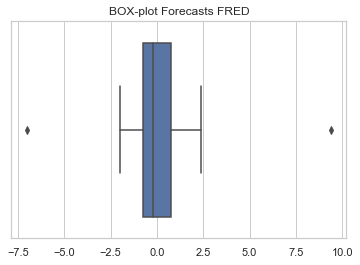

In [53]:
sns.set(style="whitegrid")

ax = sns.boxplot(x=m_ret_forward_FRED)
plt.title("BOX-plot Forecasts FRED")

Text(0.5, 1.0, 'Histogram Forecasts FRED')

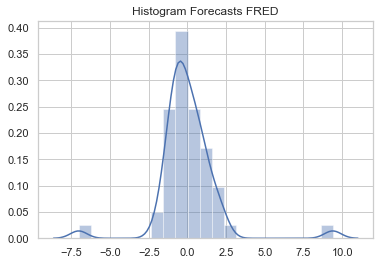

In [54]:
sns.distplot(m_ret_forward_FRED)
plt.title("Histogram Forecasts FRED")

In [55]:
## Portfolio Returns
def Portfolio_Return_FRED():
    #global Portfolio_ret_BOB
    w_equity=float(input("Enter weight on Equity: "))
    w_bond=float(input("Enter weight on Bond: "))
    
    if (w_equity+w_bond)==1:

        global Portfolio_ret_FRED
        Portfolio_ret_FRED=[]

        for j in range(0, len(m_ret_forward_FRED)):   

            if (m_ret_forward_FRED[j]>=0) & (m_ret_forward_FRED[j]<prct_75):
                p_ret=((w_equity+0.1)*m_ret[j]+(w_bond-0.1)*risk_free[j])
                message="Overweight Dow Jones ({0:2.2f}%) + Underweight US 10Y Treasury ({1:2.2f}%)".format((w_equity+0.1)*100,(w_bond-0.1)*100)

            elif m_ret_forward_FRED[j]>=prct_75:
                p_ret=((w_equity+0.2)*m_ret[j]+(w_bond-0.2)*risk_free[j])
                message="Overweight Dow Jones ({0:2.2f}%) + Underweight US 10Y Treasury ({1:2.2f}%)".format((w_equity+0.2)*100,(w_bond-0.2)*100)

            elif (m_ret_forward_FRED[j]<0) &(m_ret_forward_FRED[j]>prct_25):
                p_ret=((w_equity-0.1)*m_ret[j]+(w_bond+0.1)*risk_free[j])
                message="Underweight Dow Jones ({0:2.2f}%) + Overweight US 10Y Treasury ({1:2.2f}%)".format((w_equity-0.1)*100,(0.1+w_bond)*100)

            elif (m_ret_forward_FRED[j]<=prct_25):
                p_ret=((w_equity-0.2)*m_ret[j]+(w_bond+0.2)*risk_free[j])
                message="Underweight Dow Jones ({0:2.2f}%) + Overweight US 10Y Treasury ({1:2.2f}%)".format((w_equity-0.2)*100,(0.2+w_bond)*100)

            Portfolio_ret_FRED.append([p_ret,message])
    else:
        return print("Error: The sum of the weight must be 1")

In [56]:
Portfolio_Return_FRED()

Enter weight on Equity: 0.4
Enter weight on Bond: 0.6


In [57]:
y_pred_train_FRED=y_pred_train
FRED_Portfolio= pd.DataFrame([item[0] for item in Portfolio_ret_FRED], columns=["p_FRED_ret"], 
                              index=monthly_forecast_FRED.index)
FRED_Portfolio["message"]=pd.Series([item[1] for item in Portfolio_ret_FRED], 
                                     index=monthly_forecast_FRED.index).shift(-1).fillna("END")

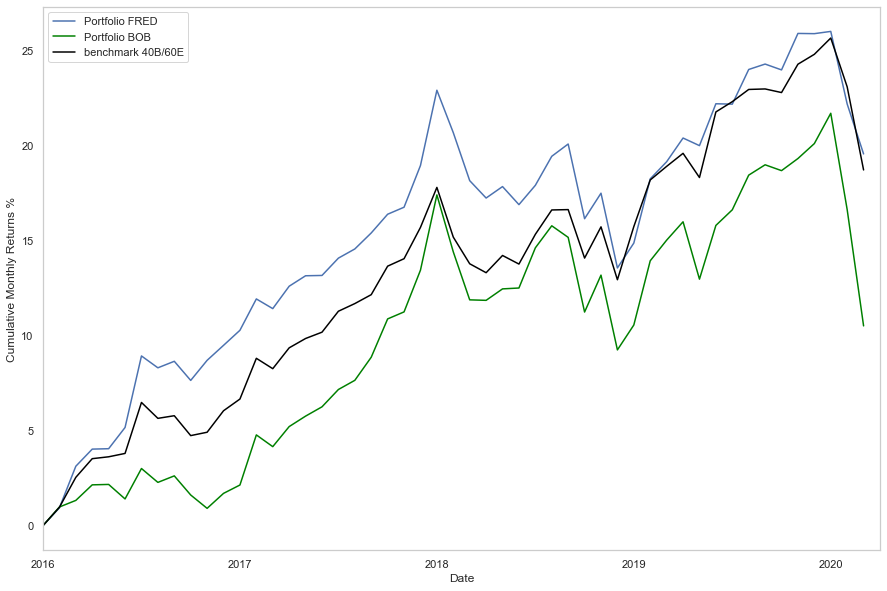

In [58]:
FRED_Portfolio.p_FRED_ret[:-1].cumsum().plot(label="Portfolio FRED", figsize=(15,10))

BOB_Portfolio.p_BOB_ret[:-1].cumsum().plot(label="Portfolio BOB",c="green")

pd.Series(benchmark, index= monthly_forecast_BOB.index[:-1]).cumsum().plot(label="benchmark 40B/60E",c="black")

plt.ylabel("Cumulative Monthly Returns %")
plt.legend(loc="best")
plt.xlim([monthly_forecast_BOB.index[:-1][0], monthly_forecast_BOB.index[0:][-1]])
plt.grid()

## ALLAN Model

               NAPMNMI1M  NAPMPMI1M  MWINCHNG2M  NFP TCH1M  LEI CHNG1M  \
NAPMNMI1M       1.000000   0.748133    0.445388   0.748654    0.457699   
NAPMPMI1M       0.748133   1.000000    0.522018   0.553339    0.550137   
MWINCHNG2M      0.445388   0.522018    1.000000   0.443305    0.208512   
NFP TCH1M       0.748654   0.553339    0.443305   1.000000    0.264191   
LEI CHNG1M      0.457699   0.550137    0.208512   0.264191    1.000000   
AAIIBULL1M      0.115669   0.089365    0.061689   0.006639    0.193903   
AAIIBEAR1M     -0.350172  -0.186597   -0.082475  -0.337845   -0.348169   
INJCJC CHNG     0.041647  -0.035599   -0.096456   0.027000   -0.016479   
CL1 CHNG        0.044829   0.102970    0.076526  -0.033225    0.222933   
VIX CHNG        0.111643   0.052138    0.000430   0.064338    0.067330   
GOLD CHNG      -0.095938  -0.035513   -0.037059  -0.104034   -0.039277   
USGG10YR CHNG  -0.001281   0.000410    0.006251  -0.052181    0.083882   
DWJ_price       0.338245   0.263009   

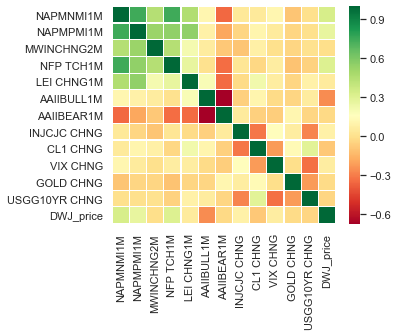

In [59]:
df_ALLAN=ALLAN.astype('float64')
df_ALLAN['DWJ_price']=INDU_monthly[ALLAN.index[0]:ALLAN.index[-1]]['DWJ_price']
df_ALLAN.columns=['NAPMNMI1M', 'NAPMPMI1M', 'MWINCHNG2M', 'NFP TCH1M', 'LEI CHNG1M', 'AAIIBULL1M',
       'AAIIBEAR1M', 'INJCJC CHNG', 'CL1 CHNG', 'VIX CHNG', 'GOLD CHNG', 'USGG10YR CHNG', 'DWJ_price']

corrmat = df_ALLAN.corr() 
print(corrmat)
f, ax = plt.subplots(figsize =(5, 4)) 
sns.heatmap(corrmat, ax = ax, cmap ="RdYlGn", linewidths = 0.1) 

In [60]:
min_max_scaler = preprocessing.MinMaxScaler()
df_ALLAN_transf= pd.DataFrame(min_max_scaler.fit_transform(df_ALLAN.drop(['DWJ_price'],axis=1)), columns=df_ALLAN.columns[:-1],
                       index=df_ALLAN.index)
df_ALLAN_transf['DWJ_price']=df_ALLAN.DWJ_price
df_ALLAN=df_ALLAN_transf

In [61]:
## Split between TRAIN & TEST Set BOB data set
X_full, y_full = np.array(df_ALLAN.drop(['DWJ_price',],axis=1)), np.array(np.log(df_ALLAN["DWJ_price"])) 

X=pd.DataFrame(X_full,index=df_ALLAN.index, columns=df_ALLAN.drop(['DWJ_price'],axis=1).columns)

X_train=np.array(X[:"2016-01-01"])
X_test=np.array(X["2016-01-01":])

y=pd.DataFrame(y_full,index=df_ALLAN.index, columns=['DWJ_price'])
y_train=list(itertools.chain.from_iterable(y[:"2016-01-01"].values))
y_test=list(itertools.chain.from_iterable(y["2016-01-01":].values))


In [62]:
parametersGrid = {"max_iter": [1000],
                      "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                      "l1_ratio": np.arange(0.0, 1.1, 0.1)}

eNet = ElasticNet()
## (cross validation 9, means about 2y in each folds)
elnet_reg_best = GridSearchCV(eNet, parametersGrid, scoring='neg_mean_squared_error', cv=9)
elnet_reg_best.fit(X_train, y_train)

GridSearchCV(cv=9, error_score='raise-deprecating',
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'max_iter': [1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [63]:
elnet_reg_best.best_estimator_, elnet_reg_best.best_params_, elnet_reg_best.best_score_

(ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.0,
            max_iter=1000, normalize=False, positive=False, precompute=False,
            random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
 {'alpha': 0.1, 'l1_ratio': 0.0, 'max_iter': 1000},
 -0.05813612027249317)

In [64]:
elnet_reg_best.best_estimator_.coef_

array([ 0.05495002,  0.05302222,  0.03919508,  0.0843381 ,  0.01184318,
       -0.03396934, -0.01471265, -0.00018045, -0.0136105 , -0.00344863,
       -0.01443248,  0.01570725])

12 features, reduction of 0.00%


Text(0.5, 1.0, "Features' importance - ALLAN Dataset")

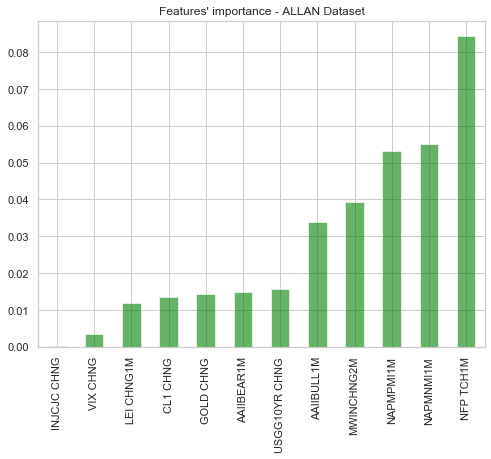

In [65]:
## feature importance
feature_importance = pd.Series(index = X.columns, data = np.abs(elnet_reg_best.best_estimator_.coef_))

n_selected_features = (feature_importance>0).sum()
print('{0:d} features, reduction of {1:2.2f}%'.format(
    n_selected_features,(1-n_selected_features/len(feature_importance))*100))

feature_importance.sort_values().tail(30).plot(kind = 'bar', figsize = (8,6), alpha=0.6, color="green")
plt.title("Features' importance - ALLAN Dataset")

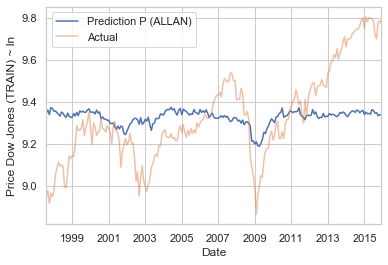

In [66]:
## TRAINING SET Predictions

y_pred_train=elnet_reg_best.predict(X_train)

## plot
pd.Series(y_pred_train, index=y[:"2016-01-01"].index).plot(label="Prediction P (ALLAN)")
pd.Series(y_train, index=y[:"2016-01-01"].index).plot(alpha=0.5, label="Actual")
plt.ylabel("Price Dow Jones (TRAIN) ~ ln")
plt.legend(loc="best")


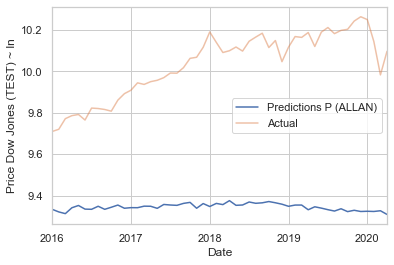

In [67]:
## TEST SET Predictions
y_pred_test=elnet_reg_best.predict(X_test)

## plot 
pd.Series(y_pred_test, index=y["2016-01-01":].index).plot(label="Predictions P (ALLAN)")
pd.Series(y_test, index=y["2016-01-01":].index).plot(alpha=0.5, label="Actual")
plt.ylabel("Price Dow Jones (TEST) ~ ln")
plt.legend(loc="best")

In [68]:
mse_test_train = mean_squared_error(y_train, y_pred_train)
mse_test_test = mean_squared_error(y_test, y_pred_test)
print("MSE (train)\n", mse_test_train)
print("MSE (test)\n", mse_test_test)

MSE (train)
 0.04362169126433355
MSE (test)
 0.49746115693056253


In [69]:
 
return_test=pd.Series(y_test, index=y["2016-01-01":].index).pct_change()
return_pred=pd.Series(y_pred_test, index=y["2016-01-01":].index).pct_change()
true_positive=0
true_negative=0
false_positive=0
false_negative=0
for i in range(1,len(return_pred)):
    
    if (return_test[i]>0) & (return_pred[i]>0):
        true_positive+=1
    elif (return_test[i]<0) & (return_pred[i]<0):
        true_negative+=1
    elif (return_test[i]>0) & (return_pred[i]<0):
        false_negative+=1
    elif (return_test[i]<0) & (return_pred[i]>0):
        false_positive+=1

        
print("Pseudo Accuracy Matrix: ")
print(true_positive, false_negative)
print( false_positive ,true_negative)


        
print("Precision Rate : {:0.2f}%".format((true_positive/(true_positive+false_positive))*100))
print("Recall Rate : {:0.2f}%".format((true_positive/(true_positive+false_negative))*100))
print("Accuracy Rate : {:0.2f}%".format(((true_positive+true_negative)/(true_positive+false_negative+true_negative+false_positive))*100))

Pseudo Accuracy Matrix: 
14 20
10 7
Precision Rate : 58.33%
Recall Rate : 41.18%
Accuracy Rate : 41.18%


In [70]:
INDU_monthly_price=pd.Series(df_ALLAN["2016-01-01":]['DWJ_price'], index=df_ALLAN["2016-01-01":].index)
# monthly return 
monthly_forecast_ALLAN=pd.Series(y_pred_test, index=y["2016-01-01":].index)

## monthly return  forecast
m_ret_forward_ALLAN=monthly_forecast_ALLAN.pct_change().fillna(0)*100

m_ret=INDU_monthly_price.pct_change().fillna(0)*100
risk_free=pd.Series(rf.resample('M').ffill()["2016-01-01":]['TY1_Futures']).pct_change().fillna(0)*100

prct_25=m_ret_forward_ALLAN.describe()["25%"] ## 25th percentile 
prct_75=m_ret_forward_ALLAN.describe()["75%"] ## 75th percentile

Text(0.5, 1.0, 'BOX-plot Forecasts ALLAN')

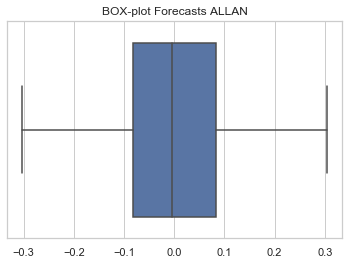

In [71]:

sns.set(style="whitegrid")

ax = sns.boxplot(x=m_ret_forward_ALLAN, orient="h")
plt.title("BOX-plot Forecasts ALLAN")

Text(0.5, 1.0, 'Histogram Forecasts ALLAN')

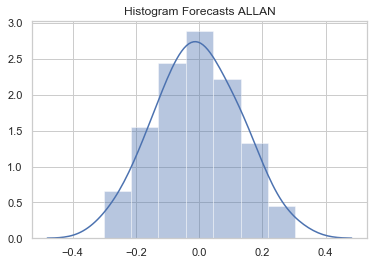

In [72]:

sns.distplot(m_ret_forward_ALLAN)
plt.title("Histogram Forecasts ALLAN")

In [73]:
def Portfolio_Return_ALLAN():

    w_equity=float(input("Enter weight on Equity: "))
    w_bond=float(input("Enter weight on Bond: "))
    
    if (w_equity+w_bond)==1:

        global Portfolio_ret_ALLAN
        Portfolio_ret_ALLAN=[]

        for j in range(0, len(m_ret_forward_ALLAN)):   

            if (m_ret_forward_ALLAN[j]>=0) & (m_ret_forward_ALLAN[j]<prct_75):
                p_ret=((w_equity+0.1)*m_ret[j]+(w_bond-0.1)*risk_free[j])
                message="Overweight Dow Jones ({0:2.2f}%) + Underweight US 10Y Treasury ({1:2.2f}%)".format((w_equity+0.1)*100,(w_bond-0.1)*100)

            elif m_ret_forward_ALLAN[j]>=prct_75:
                p_ret=((w_equity+0.2)*m_ret[j]+(w_bond-0.2)*risk_free[j])
                message="Overweight Dow Jones ({0:2.2f}%) + Underweight US 10Y Treasury ({1:2.2f}%)".format((w_equity+0.2)*100,(w_bond-0.2)*100)

            elif (m_ret_forward_ALLAN[j]<0) &(m_ret_forward_ALLAN[j]>prct_25):
                p_ret=((w_equity-0.1)*m_ret[j]+(w_bond+0.1)*risk_free[j])
                message="Underweight Dow Jones ({0:2.2f}%) + Overweight US 10Y Treasury ({1:2.2f}%)".format((w_equity-0.1)*100,(0.1+w_bond)*100)

            elif (m_ret_forward_ALLAN[j]<=prct_25):
                p_ret=((w_equity-0.2)*m_ret[j]+(w_bond+0.2)*risk_free[j])
                message="Underweight Dow Jones ({0:2.2f}%) + Overweight US 10Y Treasury ({1:2.2f}%)".format((w_equity-0.2)*100,(0.2+w_bond)*100)

            Portfolio_ret_ALLAN.append([p_ret,message])
    else:
        return print("Error: The sum of the weight must be 1")


In [74]:
Portfolio_Return_ALLAN()

Enter weight on Equity: 0.4
Enter weight on Bond: 0.6


In [75]:
y_pred_train_ALLAN=y_pred_train
ALLAN_Portfolio= pd.DataFrame([item[0] for item in Portfolio_ret_ALLAN], columns=["p_ALLAN_ret"], 
                              index=monthly_forecast_ALLAN.index)
ALLAN_Portfolio["message"]=pd.Series([item[1] for item in Portfolio_ret_ALLAN], 
                                     index=monthly_forecast_ALLAN.index).shift(-1).fillna("END")

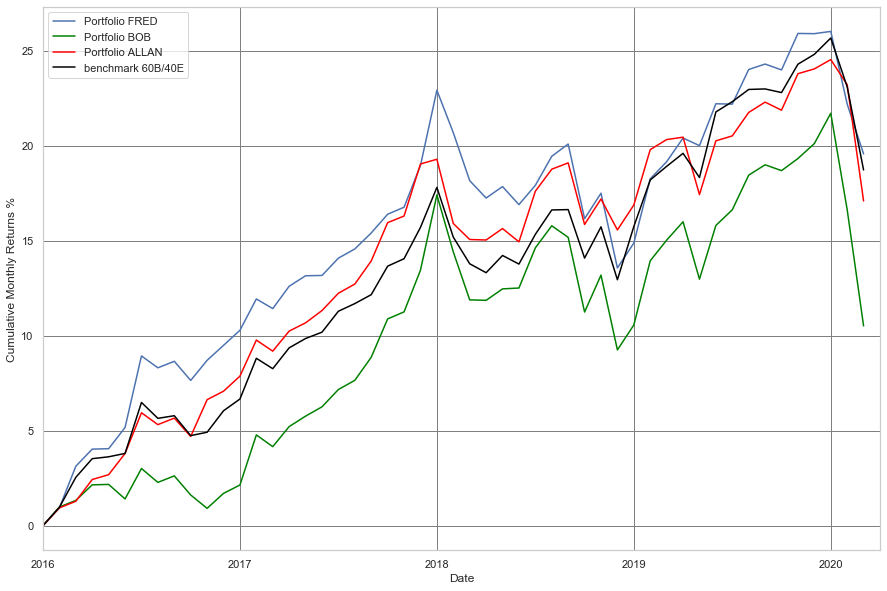

In [76]:
FRED_Portfolio.p_FRED_ret[:-1].cumsum().plot(label="Portfolio FRED", figsize=(15,10))

BOB_Portfolio.p_BOB_ret[:-1].cumsum().plot(label="Portfolio BOB",c="green")

ALLAN_Portfolio.p_ALLAN_ret[:-1].cumsum().plot(label="Portfolio ALLAN",c="red")

pd.Series(benchmark, index= monthly_forecast_BOB.index[:-1]).cumsum().plot(label="benchmark 60B/40E",c="black")



plt.ylabel("Cumulative Monthly Returns %")
plt.legend(loc="best")
plt.xlim([monthly_forecast_BOB.index[0:][0], monthly_forecast_BOB.index[1:][-1]])
plt.grid(b=True, which='major', color='grey', linestyle='-')

In [77]:
print(tabulate(BOB_Portfolio, headers='keys', tablefmt='psql'))

+---------------------+-------------+----------------------------------------------------------------------+
| Date                |   p_BOB_ret | message                                                              |
|---------------------+-------------+----------------------------------------------------------------------|
| 2016-01-31 00:00:00 |   0         | Overweight Dow Jones (50.00%) + Underweight US 10Y Treasury (50.00%) |
| 2016-02-29 00:00:00 |   0.979027  | Underweight Dow Jones (20.00%) + Overweight US 10Y Treasury (80.00%) |
| 2016-03-31 00:00:00 |   0.346196  | Underweight Dow Jones (20.00%) + Overweight US 10Y Treasury (80.00%) |
| 2016-04-30 00:00:00 |   0.819112  | Underweight Dow Jones (30.00%) + Overweight US 10Y Treasury (70.00%) |
| 2016-05-31 00:00:00 |   0.0217989 | Overweight Dow Jones (60.00%) + Underweight US 10Y Treasury (40.00%) |
| 2016-06-30 00:00:00 |  -0.763208  | Underweight Dow Jones (20.00%) + Overweight US 10Y Treasury (80.00%) |
| 2016-07-31 00:00:

In [78]:
print(tabulate(FRED_Portfolio, headers='keys', tablefmt='psql'))

+---------------------+--------------+----------------------------------------------------------------------+
| Date                |   p_FRED_ret | message                                                              |
|---------------------+--------------+----------------------------------------------------------------------|
| 2016-01-31 00:00:00 |    0         | Underweight Dow Jones (20.00%) + Overweight US 10Y Treasury (80.00%) |
| 2016-02-29 00:00:00 |    0.933623  | Overweight Dow Jones (50.00%) + Underweight US 10Y Treasury (50.00%) |
| 2016-03-31 00:00:00 |    2.18999   | Underweight Dow Jones (30.00%) + Overweight US 10Y Treasury (70.00%) |
| 2016-04-30 00:00:00 |    0.900779  | Underweight Dow Jones (30.00%) + Overweight US 10Y Treasury (70.00%) |
| 2016-05-31 00:00:00 |    0.0217989 | Underweight Dow Jones (20.00%) + Overweight US 10Y Treasury (80.00%) |
| 2016-06-30 00:00:00 |    1.11704   | Overweight Dow Jones (60.00%) + Underweight US 10Y Treasury (40.00%) |
| 2016-07-

In [79]:
print(tabulate(ALLAN_Portfolio, headers='keys', tablefmt='psql'))

+---------------------+---------------+----------------------------------------------------------------------+
| Date                |   p_ALLAN_ret | message                                                              |
|---------------------+---------------+----------------------------------------------------------------------|
| 2016-01-31 00:00:00 |     0         | Underweight Dow Jones (20.00%) + Overweight US 10Y Treasury (80.00%) |
| 2016-02-29 00:00:00 |     0.933623  | Underweight Dow Jones (20.00%) + Overweight US 10Y Treasury (80.00%) |
| 2016-03-31 00:00:00 |     0.346196  | Overweight Dow Jones (60.00%) + Underweight US 10Y Treasury (40.00%) |
| 2016-04-30 00:00:00 |     1.14578   | Overweight Dow Jones (60.00%) + Underweight US 10Y Treasury (40.00%) |
| 2016-05-31 00:00:00 |     0.252571  | Underweight Dow Jones (20.00%) + Overweight US 10Y Treasury (80.00%) |
| 2016-06-30 00:00:00 |     1.11704   | Underweight Dow Jones (30.00%) + Overweight US 10Y Treasury (70.00%) |
|

# III.	Evaluation of the Portfolios risk-adjusted returns

In [80]:
## risk free
dls = "https://fred.stlouisfed.org/graph/fredgraph.xls?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1168&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=TB3MS&scale=left&cosd=1934-01-01&coed=2020-04-01&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Monthly&fam=avg&fgst=lin&fgsnd=2009-06-01&line_index=1&transformation=lin&vintage_date=2020-05-10&revision_date=2020-05-10&nd=1934-01-01"
urllib.request.urlretrieve(dls, "TBill3M.xls")
TBill3M=pd.read_excel("TBill3M.xls")

In [81]:
risk_f= TBill3M.iloc[-2][1]

In [82]:
#eveluate the strategy ALLAN
ALLAN_return=ALLAN_Portfolio.p_ALLAN_ret[:-1]
sr_ALLAN = (ALLAN_return.mean()*12-risk_f)/(ALLAN_return.std() * np.sqrt(12))
sortino_ALLAN = (ALLAN_return.mean()*12-risk_f)/(ALLAN_return[ALLAN_return<0].std() * np.sqrt(12))

Text(0.5, 1.0, 'Portfolio ALLAN return volatility')

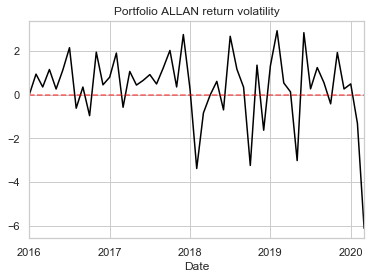

In [83]:
ALLAN_return.plot(color="black")
pd.Series([0]*len(ALLAN_return), index=ALLAN_return.index).plot(color="red",linestyle="--", alpha=0.6)
plt.title("Portfolio ALLAN return volatility")

In [84]:
#eveluate the strategy FRED
FRED_return=FRED_Portfolio.p_FRED_ret[:-1]
sr_FRED = (FRED_return.mean()*12-risk_f)/(FRED_return.std() * np.sqrt(12))
sortino_FRED = (FRED_return.mean()*12-risk_f)/(FRED_return[FRED_return<0].std() * np.sqrt(12))

Text(0.5, 1.0, 'Portfolio FRED return volatility')

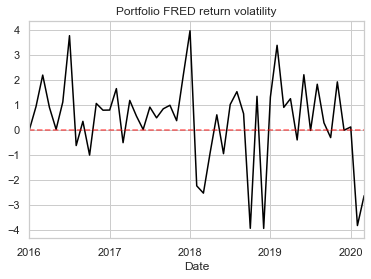

In [85]:
FRED_return.plot(color="black")
pd.Series([0]*len(FRED_return), index=FRED_return.index).plot(color="red",linestyle="--", alpha=0.6)
plt.title("Portfolio FRED return volatility")

In [86]:
#eveluate the strategy BOB
BOB_return=BOB_Portfolio.p_BOB_ret[:-1]
sr_BOB = (BOB_return.mean()*12-risk_f)/(BOB_return.std() * np.sqrt(12))
sortino_BOB = (BOB_return.mean()*12-risk_f)/(BOB_return[BOB_return<0].std() * np.sqrt(12))

Text(0.5, 1.0, 'Portfolio BOB return volatility')

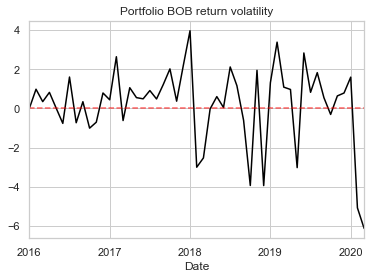

In [87]:
BOB_return.plot(color="black")
pd.Series([0]*len(BOB_return), index=BOB_return.index).plot(color="red",linestyle="--", alpha=0.6)
plt.title("Portfolio BOB return volatility")

In [88]:
benchmark_ret=pd.Series(benchmark, index= monthly_forecast_FRED.index[:-1]) #[:-2] !!
sr_benchmark = (benchmark_ret.mean()*12-risk_f)/(benchmark_ret.std() * np.sqrt(12))
sortino_benchmark = (benchmark_ret.mean()*12-risk_f)/(benchmark_ret[benchmark_ret<0].std() * np.sqrt(12))

In [89]:
(beta_BOB, alpha_BOB) = stats.linregress(benchmark_ret,BOB_return)[0:2]  #[:"2019-08-31"]
(beta_FRED, alpha_FRED) = stats.linregress(benchmark_ret,FRED_return)[0:2] 
(beta_ALLAN, alpha_ALLAN) = stats.linregress(benchmark_ret,ALLAN_return)[0:2] 
#benchmark_ret[:"2019-08-31"], FRED_return[:"2019-08-31"]

In [90]:
print("The Sharpe Ratio with Buy+Hold Strategy (Benchmark) is: {}".format(sr_benchmark))
print("The Sortino Ratio with Buy+Hold Strategy (Benchmark) is: {}".format(sortino_benchmark))

print("The annualized standard dev with Buy+Hold Strategy (Benchmark) is: {}".format(benchmark_ret.std() * np.sqrt(12)))
print("The annualized return with Benchmark Model is: {}%".format(benchmark_ret.mean()*(12)))
print("The Maximum Drawdown is: {}%".format(round(min(benchmark_ret),4)))
print('The Positive months are {} and the Negative months are {}'.format(benchmark_ret[benchmark_ret>0].count(),
                                                                     benchmark_ret[benchmark_ret<0].count()))
print('The YTM {}%'.format(round(benchmark_ret['2020-01-01':].cumsum()[-1],4)))

The Sharpe Ratio with Buy+Hold Strategy (Benchmark) is: 0.7830153315773815
The Sortino Ratio with Buy+Hold Strategy (Benchmark) is: 0.9515855846537894
The annualized standard dev with Buy+Hold Strategy (Benchmark) is: 5.2536373777243774
The annualized return with Benchmark Model is: 4.4036786133061785%
The Maximum Drawdown is: -4.3735%
The Positive months are 37 and the Negative months are 13
The YTM -6.0856%


In [91]:
print("The Sharpe Ratio with BOB Model is: {}".format(sr_BOB))
print("The Sortino Ratio with BOB Model is: {}".format(sortino_BOB))
print("The annualized standard dev with BOB Model is: {}".format(BOB_return.std() * np.sqrt(12)))
print("The annualized return with BOB Model is: {}%".format(BOB_return.mean()*(12)))
print("The  Beta with BOB Model is: {}".format(beta_BOB))
print("The annualized alpha with BOB Model is: {}".format(alpha_BOB*12))
print("The Maximum Drawdown is: {}%".format(round(min(BOB_return),4)))
print('The Positive months are {} and the Negative months are {}'.format(BOB_return[BOB_return>0].count(),
                                                                     BOB_return[BOB_return<0].count()))
print('The YTM {}%'.format(round(BOB_return['2020-01-01':].cumsum()[-1],4)))
print("Total number of months BOB overperform Buy+Hold: {}".format(sum(BOB_return>benchmark_ret)))

The Sharpe Ratio with BOB Model is: 0.31344840034259885
The Sortino Ratio with BOB Model is: 0.32622262768622917
The annualized standard dev with BOB Model is: 6.963597106695177
The annualized return with BOB Model is: 2.472728373723953%
The  Beta with BOB Model is: 1.23384360672359
The annualized alpha with BOB Model is: -2.96072232936928
The Maximum Drawdown is: -6.1191%
The Positive months are 35 and the Negative months are 15
The YTM -9.5946%
Total number of months BOB overperform Buy+Hold: 24


In [92]:
print("The Sharpe Ratio with FRED Model is: {}".format(sr_FRED))
print("The Sortino Ratio with FRED Model is: {}".format(sortino_FRED))
print("The annualized standard dev with FRED Model is: {}".format(FRED_return.std() * np.sqrt(12)))
print("The annualized return with FRED Model is: {}%".format(FRED_return.mean()*(12)))
print("The  Beta with FRED Model is: {}".format(beta_FRED))
print("The annualized alpha with FRED Model is: {}".format(alpha_FRED*12))
print("The Maximum Drawdown is: {}%".format(round(min(FRED_return),4)))
print('The Positive months are {} and the Negative months are {}'.format(FRED_return[FRED_return>0].count(),
                                                                     FRED_return[FRED_return<0].count()))
print('The YTM {}%'.format(round(FRED_return['2020-01-01':].cumsum()[-1],4)))
print("Total number of months FRED overperform Buy+Hold: {}".format(sum(FRED_return>benchmark_ret)))

The Sharpe Ratio with FRED Model is: 0.7295723075373769
The Sortino Ratio with FRED Model is: 0.8555967162463646
The annualized standard dev with FRED Model is: 5.9104300973612425
The annualized return with FRED Model is: 4.602086124670205%
The  Beta with FRED Model is: 1.0147033713728901
The annualized alpha with FRED Model is: 0.13365858930573293
The Maximum Drawdown is: -3.9349%
The Positive months are 35 and the Negative months are 15
The YTM -6.3294%
Total number of months FRED overperform Buy+Hold: 26


In [93]:
print("The Sharpe Ratio with ALLAN Model is: {}".format(sr_ALLAN))
print("The Sortino Ratio with ALLAN Model is: {}".format(sortino_ALLAN))
print("The annualized standard dev with ALLAN Model is: {}".format(ALLAN_return.std() * np.sqrt(12)))
print("The annualized return with ALLAN Model is: {}%".format(ALLAN_return.mean()*(12)))
print("The  Beta with ALLAN Model is: {}".format(beta_ALLAN))
print("The annualized alpha with ALLAN Model is: {}".format(alpha_ALLAN*12))
print("The Maximum Drawdown is: {}%".format(round(min(ALLAN_return),4)))
print('The Positive months are {} and the Negative months are {}'.format(ALLAN_return[ALLAN_return>0].count(),
                                                                     ALLAN_return[ALLAN_return<0].count()))
print('The YTM {}%'.format(round(ALLAN_return['2020-01-01':].cumsum()[-1],4)))
print("Total number of months ALLAN overperform Buy+Hold: {}".format(sum(ALLAN_return>benchmark_ret)))

The Sharpe Ratio with ALLAN Model is: 0.6485472757373182
The Sortino Ratio with ALLAN Model is: 0.624421004850202
The annualized standard dev with ALLAN Model is: 5.751319530528358
The annualized return with ALLAN Model is: 4.020002613418998%
The  Beta with ALLAN Model is: 0.9753419861699624
The annualized alpha with ALLAN Model is: -0.2750900317372351
The Maximum Drawdown is: -6.1191%
The Positive months are 37 and the Negative months are 13
The YTM -6.9495%
Total number of months ALLAN overperform Buy+Hold: 23


# IV.	Final evaluation of the Portfolio based on risk-adjusted returns

In [94]:
TY1= (pd.Series(rf.resample('M').ffill()["2015-06-01":]['TY1_Futures']))
return_TY1=[]
for i in range(len(TY1)-1):
    return_TY1.append(np.log(TY1[i+1]/TY1[i]))
rf_vol= (pd.Series(return_TY1, index=TY1.index[1:],name="TY1_Futures")).rolling(6).std()* np.sqrt(12)

In [95]:
INDU_p= (pd.Series(INDU.resample('M').ffill()["2015-06-01":]['DWJ_price']))

vol_ret_INDU=[]
for i in range(len(INDU_p)-1):
    vol_ret_INDU.append(np.log(INDU_p[i+1]/INDU_p[i]))
vol_ret_INDU= (pd.Series(vol_ret_INDU, index=INDU_p.index[1:],name="INDU")).rolling(6).std()* np.sqrt(12)

In [96]:
trgt_vol=0.07
contribution=0.50
w_vol_B= (trgt_vol*2)*contribution/rf_vol 
w_vol_E= (trgt_vol*2)*contribution/vol_ret_INDU 


In [97]:
w_volatility=(w_vol_B).to_frame().join(w_vol_E)
w_volatility["sum"] = w_volatility.sum(axis=1)

In [98]:
leveragex2=2.0
leveragex1_5=1.5

In [99]:
w_volatility["w_E_vol_trgtx2"] = np.where(w_volatility.iloc[:,2]>leveragex2,
                                              (w_volatility.iloc[:,1]/w_volatility.iloc[:,2])*leveragex2,
                                              w_volatility.iloc[:,1] )
w_volatility["w_B_vol_trgtx2"] = np.where(w_volatility.iloc[:,2]>leveragex2,
                                              (w_volatility.iloc[:,0]/w_volatility.iloc[:,2])*leveragex2,
                                              w_volatility.iloc[:,0] )
w_volatility["w_E_vol_trgtx1_5"] = np.where(w_volatility.iloc[:,2]>leveragex1_5,
                                              (w_volatility.iloc[:,1]/w_volatility.iloc[:,2])*leveragex1_5,
                                              w_volatility.iloc[:,1] )
w_volatility["w_B_vol_trgtx1_5"] = np.where(w_volatility.iloc[:,2]>leveragex1_5,
                                              (w_volatility.iloc[:,0]/w_volatility.iloc[:,2])*leveragex1_5,
                                              w_volatility.iloc[:,0] )

In [100]:
w_volatility.dropna(inplace=True)

In [101]:
## ALLAN

def Portfolio_Return_ALLAN_v():

    w_equity=float(input("Enter weight on Equity: "))
    w_bond=float(input("Enter weight on Bond: "))
    
    if (w_equity+w_bond)==1:

        global Portfolio_ret_ALLAN_vol
        Portfolio_ret_ALLAN_vol=[]

        for j in range(0, len(m_ret_forward_ALLAN)):   

            if (m_ret_forward_ALLAN[j]>=0) & (m_ret_forward_ALLAN[j]<np.percentile(m_ret_forward_ALLAN,75)):
                p_ret=((w_equity+0.1)*m_ret[j]+(w_bond-0.1)*risk_free[j])
                message="Overweight Dow Jones ({0:2.2f}%) + Underweight US 10Y Treasury ({1:2.2f}%)".format((w_equity+0.1)*100,(w_bond-0.1)*100)

            elif m_ret_forward_ALLAN[j]>=np.percentile(m_ret_forward_ALLAN,75):
                p_ret=((w_equity+0.2)*m_ret[j]+(w_bond-0.2)*risk_free[j])
                message="Overweight Dow Jones ({0:2.2f}%) + Underweight US 10Y Treasury ({1:2.2f}%)".format((w_equity+0.2)*100,(w_bond-0.2)*100)


            elif (m_ret_forward_ALLAN[j]<0) &(m_ret_forward_ALLAN[j]>np.percentile(m_ret_forward_ALLAN,25),):
                p_ret=(w_volatility[:-1].w_E_vol_trgtx1_5[j]*m_ret[j]+w_volatility[:-1].w_B_vol_trgtx1_5[j]*risk_free[j])
                message="Risk Parity, leverage {}".format(leveragex1_5)
                
            elif (m_ret_forward_ALLAN[j]<=np.percentile(m_ret_forward_ALLAN,25)):
                p_ret=(w_volatility[:-1].w_E_vol_trgtx2[j]*m_ret[j]+w_volatility[:-1].w_B_vol_trgtx2[j]*risk_free[j])
                message="Risk Parity, leverage {}".format(leveragex2)
                
            Portfolio_ret_ALLAN_vol.append([p_ret,message])
    else:
        return print("Error: The sum of the weight must be 1")

    
## BOB

def Portfolio_Return_BOB_v():

    w_equity=float(input("Enter weight on Equity: "))
    w_bond=float(input("Enter weight on Bond: "))
    
    if (w_equity+w_bond)==1:

        global Portfolio_ret_BOB_vol
        Portfolio_ret_BOB_vol=[]

        for j in range(0, len(m_ret_forward_BOB)):   

            if (m_ret_forward_BOB[j]>=0) & (m_ret_forward_BOB[j]<np.percentile(m_ret_forward_BOB,75)):
                p_ret=((w_equity+0.1)*m_ret[j]+(w_bond-0.1)*risk_free[j])
                message="Overweight Dow Jones ({0:2.2f}%) + Underweight US 10Y Treasury ({1:2.2f}%)".format((w_equity+0.1)*100,(w_bond-0.1)*100)     

            elif m_ret_forward_BOB[j]>=np.percentile(m_ret_forward_BOB,75):
                p_ret=((w_equity+0.2)*m_ret[j]+(w_bond-0.2)*risk_free[j])
                message="Overweight Dow Jones ({0:2.2f}%) + Underweight US 10Y Treasury ({1:2.2f}%)".format((w_equity+0.2)*100,(w_bond-0.2)*100)

            elif (m_ret_forward_BOB[j]<0) &(m_ret_forward_BOB[j]>np.percentile(m_ret_forward_BOB,25)):
                p_ret=(w_volatility[:-1].w_E_vol_trgtx1_5[j]*m_ret[j]+w_volatility[:-1].w_B_vol_trgtx1_5[j]*risk_free[j])
                message="Risk Parity, leverage {}".format(leveragex1_5)
                
            elif (m_ret_forward_BOB[j]<=np.percentile(m_ret_forward_BOB,25)):
                p_ret=(w_volatility[:-1].w_E_vol_trgtx2[j]*m_ret[j]+w_volatility[:-1].w_B_vol_trgtx2[j]*risk_free[j])
                message="Risk Parity, leverage {}".format(leveragex2)


            Portfolio_ret_BOB_vol.append([p_ret,message])
    else:
        return print("Error: The sum of the weight must be 1")
        
## FRED
        
def Portfolio_Return_FRED_v():

    w_equity=float(input("Enter weight on Equity: "))
    w_bond=float(input("Enter weight on Bond: "))
    
    if (w_equity+w_bond)==1:
        
        global Portfolio_ret_FRED_vol
        Portfolio_ret_FRED_vol=[]

        for j in range(0, len(m_ret_forward_FRED)):   

            if (m_ret_forward_FRED[j]>=0) & (m_ret_forward_FRED[j]<np.percentile(m_ret_forward_FRED,75)):
                p_ret=((w_equity+0.1)*m_ret[j]+(w_bond-0.1)*risk_free[j])
                message="Overweight Dow Jones ({0:1.2f}%) + Underweight US 10Y Treasury ({1:2.2f}%)".format((w_equity+0.1)*100,(w_bond-0.1)*100)

            elif m_ret_forward_FRED[j]>=np.percentile(m_ret_forward_FRED,75):
                p_ret=((w_equity+0.2)*m_ret[j]+(w_bond-0.2)*risk_free[j])
                message="Overweight Dow Jones ({0:2.2f}%) + Underweight US 10Y Treasury ({1:2.2f}%)".format((w_equity+0.2)*100,(w_bond-0.2)*100)

            elif (m_ret_forward_FRED[j]<0) &(m_ret_forward_FRED[j]>np.percentile(m_ret_forward_FRED,25)):
                p_ret=(w_volatility[:-1].w_E_vol_trgtx1_5[j]*m_ret[j]+w_volatility[:-1].w_B_vol_trgtx1_5[j]*risk_free[j])
                message="Risk Parity, leverage {}".format(leveragex1_5)
                
            elif (m_ret_forward_FRED[j]<=np.percentile(m_ret_forward_FRED,25)):
                p_ret=(w_volatility[:-1].w_E_vol_trgtx2[j]*m_ret[j]+w_volatility[:-1].w_B_vol_trgtx2[j]*risk_free[j])
                message="Risk Parity, leverage {}".format(leveragex2)
                
            Portfolio_ret_FRED_vol.append([p_ret,message])
    else:
        return print("Error: The sum of the weight must be 1")

In [102]:
Portfolio_Return_ALLAN_v()

Enter weight on Equity: 0.4
Enter weight on Bond: 0.6


In [103]:
Portfolio_Return_BOB_v()

Enter weight on Equity: 0.4
Enter weight on Bond: 0.6


In [104]:
Portfolio_Return_FRED_v()

Enter weight on Equity: 0.4
Enter weight on Bond: 0.6


In [105]:
ALLAN_Vol_Portfolio= pd.DataFrame([item[0] for item in Portfolio_ret_ALLAN_vol], columns=["p_Vol_ALLAN_ret"], 
                              index=monthly_forecast_ALLAN.index)
ALLAN_Vol_Portfolio["message"]=pd.Series([item[1] for item in Portfolio_ret_ALLAN_vol], 
                                     index=monthly_forecast_ALLAN.index).shift(-1).fillna("END")

FRED_Vol_Portfolio= pd.DataFrame([item[0] for item in Portfolio_ret_FRED_vol], columns=["p_Vol_FRED_ret"], 
                              index=monthly_forecast_FRED.index)
FRED_Vol_Portfolio["message"]=pd.Series([item[1] for item in Portfolio_ret_FRED_vol], 
                                     index=monthly_forecast_FRED.index).shift(-1).fillna("END")

BOB_Vol_Portfolio= pd.DataFrame([item[0] for item in Portfolio_ret_BOB_vol], columns=["p_Vol_BOB_ret"], 
                              index=monthly_forecast_BOB.index)
BOB_Vol_Portfolio["message"]=pd.Series([item[1] for item in Portfolio_ret_BOB_vol], 
                                     index=monthly_forecast_BOB.index).shift(-1).fillna("END")

In [106]:
## Benchmark 40 Equity + 60 US 10Y Treasury Bill
risk_parityx1_5=[]
for j in range(0, len(w_volatility)-1):
    res=(w_volatility.w_E_vol_trgtx1_5[j]*m_ret[j]+w_volatility.w_B_vol_trgtx1_5[j]*risk_free[j])
    risk_parityx1_5.append(res)

risk_parityx2=[]
for j in range(0, len(w_volatility)-1):
    res=(w_volatility.w_E_vol_trgtx2[j]*m_ret[j]+w_volatility.w_B_vol_trgtx2[j]*risk_free[j])
    risk_parityx2.append(res)

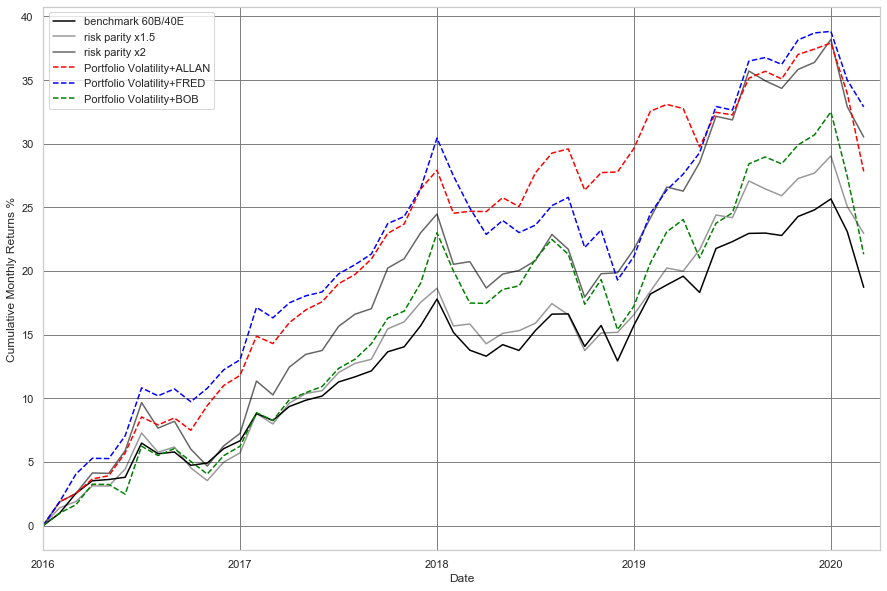

In [107]:
pd.Series(benchmark, index= monthly_forecast_BOB.index[:-1]).cumsum().plot(label="benchmark 60B/40E",c="black", figsize=(15,10))

pd.Series(risk_parityx1_5[:-1], index= monthly_forecast_BOB.index[:-1]).cumsum().plot(label="risk parity x1.5",c="black", 
                                                                                       figsize=(15,10),alpha=0.4)
pd.Series(risk_parityx2[:-1], index= monthly_forecast_BOB.index[:-1]).cumsum().plot(label="risk parity x2",c="black", alpha=0.6)

ALLAN_Vol_Portfolio.p_Vol_ALLAN_ret[:-1].cumsum().plot(label="Portfolio Volatility+ALLAN",c="red", style='--')
FRED_Vol_Portfolio.p_Vol_FRED_ret[:-1].cumsum().plot(label="Portfolio Volatility+FRED",c="blue", style='--')
BOB_Vol_Portfolio.p_Vol_BOB_ret[:-1].cumsum().plot(label="Portfolio Volatility+BOB",c="green", style='--')


plt.ylabel("Cumulative Monthly Returns %")
plt.legend(loc="best")
plt.xlim([monthly_forecast_BOB.index[0:][0], monthly_forecast_BOB.index[1:][-1]])
plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.show()

Text(0.5, 1.0, 'Portfolio ALLAN+Risk Parity return volatility')

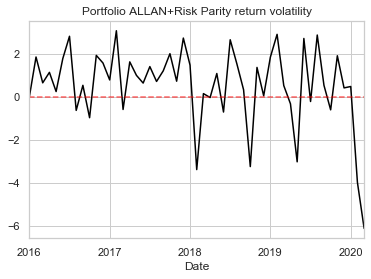

In [108]:
#eveluate the strategy ALLAN
ALLAN_return_vol=ALLAN_Vol_Portfolio.p_Vol_ALLAN_ret[:-1]
sr_ALLAN = (ALLAN_return_vol.mean()*12-risk_f)/(ALLAN_return_vol.std() * np.sqrt(12))
sortino_ALLAN = (ALLAN_return_vol.mean()*12-risk_f)/(ALLAN_return_vol[ALLAN_return_vol<0].std() * np.sqrt(12))

ALLAN_return_vol.plot(color="black")
pd.Series([0]*len(ALLAN_return_vol), index=ALLAN_return_vol.index).plot(color="red",linestyle="--", alpha=0.6)
plt.title("Portfolio ALLAN+Risk Parity return volatility")

Text(0.5, 1.0, 'Portfolio FRED+Risk Parity return volatility')

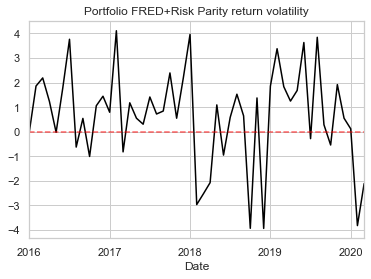

In [109]:
#eveluate the strategy FRED
FRED_return_vol=FRED_Vol_Portfolio.p_Vol_FRED_ret[:-1]
sr_FRED = (FRED_return_vol.mean()*12-risk_f)/(FRED_return_vol.std() * np.sqrt(12))
sortino_FRED = (FRED_return_vol.mean()*12-risk_f)/(FRED_return_vol[FRED_return_vol<0].std() * np.sqrt(12))

FRED_return_vol.plot(color="black")
pd.Series([0]*len(FRED_return_vol), index=FRED_return_vol.index).plot(color="red",linestyle="--", alpha=0.6)
plt.title("Portfolio FRED+Risk Parity return volatility")

Text(0.5, 1.0, 'Portfolio BOB+Risk Parity return volatility')

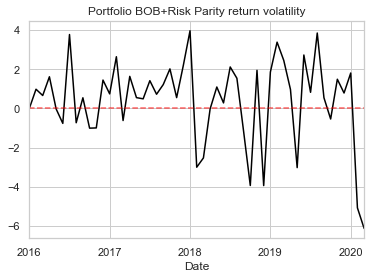

In [110]:
#eveluate the strategy BOB
BOB_return_vol=BOB_Vol_Portfolio.p_Vol_BOB_ret[:-1]
sr_BOB = (BOB_return_vol.mean()*12-risk_f)/(BOB_return_vol.std() * np.sqrt(12))
sortino_BOB = (BOB_return_vol.mean()*12-risk_f)/(BOB_return_vol[BOB_return_vol<0].std() * np.sqrt(12))

BOB_return_vol.plot(color="black")
pd.Series([0]*len(BOB_return_vol), index=BOB_return_vol.index).plot(color="red",linestyle="--", alpha=0.6)
plt.title("Portfolio BOB+Risk Parity return volatility")

In [111]:
(beta_BOB, alpha_BOB) = stats.linregress(benchmark_ret,BOB_return_vol)[0:2] 
(beta_FRED, alpha_FRED) = stats.linregress(benchmark_ret,FRED_return_vol)[0:2] 
(beta_ALLAN, alpha_ALLAN) = stats.linregress(benchmark_ret,ALLAN_return_vol)[0:2]

In [112]:
print("The Sharpe Ratio with BOB Model is: {}".format(sr_BOB))
print("The Sortino Ratio with BOB Model is: {}".format(sortino_BOB))
print("The annualized standard dev with BOB Model is: {}".format(BOB_return_vol.std() * np.sqrt(12)))
print("The annualized return with BOB Model is: {}%".format(BOB_return_vol.mean()*(12)))
print("The  Beta with BOB Model is: {}".format(beta_BOB))
print("The annualized alpha with BOB Model is: {}".format(alpha_BOB*12))
print("The Maximum Drawdown is: {}%".format(round(min(BOB_return_vol),4)))
print('The Positive months are {} and the Negative months are {}'.format(BOB_return_vol[BOB_return_vol>0].count(),
                                                                     BOB_return_vol[BOB_return_vol<0].count()))
print('The YTM {}%'.format(round(BOB_return_vol['2020-01-01':].cumsum()[-1],4)))
print("Total number of months BOB overperform Buy+Hold: {}".format(sum(BOB_return_vol>benchmark_ret)))
print("Total number of months BOB overperform RP1.5: {}".format(sum(BOB_return_vol>risk_parityx1_5[:-1])))
print("Total number of months BOB overperform RP2: {}".format(sum(BOB_return_vol>risk_parityx2[:-1])))

The Sharpe Ratio with BOB Model is: 0.6251404894124207
The Sortino Ratio with BOB Model is: 0.7205443722484935
The annualized standard dev with BOB Model is: 7.556824800118834
The annualized return with BOB Model is: 5.014077153950207%
The  Beta with BOB Model is: 1.3306648989704961
The annualized alpha with BOB Model is: -0.8457434031233921
The Maximum Drawdown is: -6.1191%
The Positive months are 34 and the Negative months are 16
The YTM -9.3838%
Total number of months BOB overperform Buy+Hold: 33
Total number of months BOB overperform RP1.5: 26
Total number of months BOB overperform RP2: 20


In [113]:
print("The Sharpe Ratio with FRED Model is: {}".format(sr_FRED))
print("The Sortino Ratio with FRED Model is: {}".format(sortino_FRED))
print("The annualized standard dev with FRED Model is: {}".format(FRED_return_vol.std() * np.sqrt(12)))
print("The annualized return with FRED Model is: {}%".format(FRED_return_vol.mean()*(12)))
print("The  Beta with FRED Model is: {}".format(beta_FRED))
print("The annualized alpha with FRED Model is: {}".format(alpha_FRED*12))
print("The Maximum Drawdown is: {}%".format(round(min(FRED_return_vol),4)))
print('The Positive months are {} and the Negative months are {}'.format(FRED_return_vol[FRED_return_vol>0].count(),
                                                                     FRED_return_vol[FRED_return_vol<0].count()))
print('The YTM {}%'.format(round(FRED_return_vol['2020-01-01':].cumsum()[-1],4)))
print("Total number of months FRED overperform Buy+Hold: {}".format(sum(FRED_return_vol>benchmark_ret)))
print("Total number of months FRED overperform RP1.5: {}".format(sum(FRED_return_vol>risk_parityx1_5[:-1])))
print("Total number of months FRED overperform RP2: {}".format(sum(FRED_return_vol>risk_parityx2[:-1])))

The Sharpe Ratio with FRED Model is: 1.0968806643831017
The Sortino Ratio with FRED Model is: 1.5215482168003502
The annualized standard dev with FRED Model is: 6.791222651450162
The annualized return with FRED Model is: 7.7391608138962225%
The  Beta with FRED Model is: 1.115390127384
The annualized alpha with FRED Model is: 2.8273411644424504
The Maximum Drawdown is: -3.9349%
The Positive months are 36 and the Negative months are 14
The YTM -5.811%
Total number of months FRED overperform Buy+Hold: 34
Total number of months FRED overperform RP1.5: 25
Total number of months FRED overperform RP2: 18


In [114]:
print("The Sharpe Ratio with ALLAN Model is: {}".format(sr_ALLAN))
print("The Sortino Ratio with ALLAN Model is: {}".format(sortino_ALLAN))
print("The annualized standard dev with ALLAN Model is: {}".format(ALLAN_return_vol.std() * np.sqrt(12)))
print("The annualized return with ALLAN Model is: {}%".format(ALLAN_return_vol.mean()*(12)))
print("The  Beta with ALLAN Model is: {}".format(beta_ALLAN))
print("The annualized alpha with ALLAN Model is: {}".format(alpha_ALLAN*12))
print("The Maximum Drawdown is: {}%".format(round(min(ALLAN_return_vol),4)))
print('The Positive months are {} and the Negative months are {}'.format(ALLAN_return_vol[ALLAN_return>0].count(),
                                                                     ALLAN_return_vol[ALLAN_return<0].count()))
print('The YTM {}%'.format(round(ALLAN_return_vol['2020-01-01':].cumsum()[-1],4)))
print("Total number of months ALLAN overperform Buy+Hold: {}".format(sum(ALLAN_return_vol>benchmark_ret)))
print("Total number of months ALLAN overperform RP1.5: {}".format(sum(ALLAN_return_vol>risk_parityx1_5[:-1])))
print("Total number of months ALLAN overperform RP2: {}".format(sum(ALLAN_return_vol>risk_parityx2[:-1])))

The Sharpe Ratio with ALLAN Model is: 0.9725336662064932
The Sortino Ratio with ALLAN Model is: 0.9481300999164834
The annualized standard dev with ALLAN Model is: 6.43262680920768
The annualized return with ALLAN Model is: 6.545946134096922%
The  Beta with ALLAN Model is: 1.071856820686711
The annualized alpha with ALLAN Model is: 1.8258331763124946
The Maximum Drawdown is: -6.1191%
The Positive months are 37 and the Negative months are 13
The YTM -9.6102%
Total number of months ALLAN overperform Buy+Hold: 32
Total number of months ALLAN overperform RP1.5: 25
Total number of months ALLAN overperform RP2: 18


In [115]:
print(tabulate(BOB_Vol_Portfolio, headers='keys', tablefmt='psql'))

+---------------------+-----------------+----------------------------------------------------------------------+
| Date                |   p_Vol_BOB_ret | message                                                              |
|---------------------+-----------------+----------------------------------------------------------------------|
| 2016-01-31 00:00:00 |       0         | Overweight Dow Jones (50.00%) + Underweight US 10Y Treasury (50.00%) |
| 2016-02-29 00:00:00 |       0.979027  | Risk Parity, leverage 2.0                                            |
| 2016-03-31 00:00:00 |       0.658943  | Risk Parity, leverage 2.0                                            |
| 2016-04-30 00:00:00 |       1.6148    | Risk Parity, leverage 1.5                                            |
| 2016-05-31 00:00:00 |      -0.0226078 | Overweight Dow Jones (60.00%) + Underweight US 10Y Treasury (40.00%) |
| 2016-06-30 00:00:00 |      -0.763208  | Risk Parity, leverage 2.0                             

In [116]:
print(tabulate(FRED_Vol_Portfolio, headers='keys', tablefmt='psql'))

+---------------------+------------------+----------------------------------------------------------------------+
| Date                |   p_Vol_FRED_ret | message                                                              |
|---------------------+------------------+----------------------------------------------------------------------|
| 2016-01-31 00:00:00 |        0         | Risk Parity, leverage 2.0                                            |
| 2016-02-29 00:00:00 |        1.86087   | Overweight Dow Jones (50.00%) + Underweight US 10Y Treasury (50.00%) |
| 2016-03-31 00:00:00 |        2.18999   | Risk Parity, leverage 1.5                                            |
| 2016-04-30 00:00:00 |        1.23586   | Risk Parity, leverage 1.5                                            |
| 2016-05-31 00:00:00 |       -0.0226078 | Risk Parity, leverage 2.0                                            |
| 2016-06-30 00:00:00 |        1.7892    | Overweight Dow Jones (60.00%) + Underweight U

In [117]:
print(tabulate(ALLAN_Vol_Portfolio, headers='keys', tablefmt='psql'))

+---------------------+-------------------+----------------------------------------------------------------------+
| Date                |   p_Vol_ALLAN_ret | message                                                              |
|---------------------+-------------------+----------------------------------------------------------------------|
| 2016-01-31 00:00:00 |         0         | Risk Parity, leverage 2.0                                            |
| 2016-02-29 00:00:00 |         1.86087   | Risk Parity, leverage 2.0                                            |
| 2016-03-31 00:00:00 |         0.658943  | Overweight Dow Jones (60.00%) + Underweight US 10Y Treasury (40.00%) |
| 2016-04-30 00:00:00 |         1.14578   | Overweight Dow Jones (60.00%) + Underweight US 10Y Treasury (40.00%) |
| 2016-05-31 00:00:00 |         0.252571  | Risk Parity, leverage 2.0                                            |
| 2016-06-30 00:00:00 |         1.7892    | Risk Parity, leverage 1.5           